# Проект "Классификация товара" (соревнование от KazanExpress)

### Описание задачи

На маркетплейсе <code>[KazanExpress](https://kazanexpress.ru/ "kazanexpress.ru - интернет-магазин с бесплатной доставкой за 1 день")</code> ежедневно появляются сотни новых товаров. Однако, проверить правильность заполнения информации обо всех товарах сразу невозможно. Неверно определенная категория зачастую приводит к потенциально упущенной прибыли как со стороны продавца, так и со стороны маркетплейса. Нам необходимо научиться предсказывать категорию на основе описания, картинки и других параметров товаров

### Описание данных

В нашем распоряжении следующие файлы:

1. `train.parquet` – датафрейм *pandas* в формате *parquet* с информацией о товарах на маркетплейсе. Для каждого товара имеются следующие поля:
<div>

    - *product_id* – идентификатор товара
    - *category_id* – идентификатор категории товара (таргет)
    - *sale* – флаг, обозначающий находится ли товар в распродаже
    - *shop_id* – идентификатор магазина, продавца
    - *shop_title* – название магазина
    - *rating* – средний рейтинг товара
    - *text_fields* – строка-словарь со следующими полями:
        - *title* – заголовок
        - *description* – описание
        - *attributes* – на сайте они находятся в карточке товара
        - *custom_characteristics*, *defined_characteristics*, *filters* – вложенные словари с названиями полей-признаков в качестве ключа и возможными значениями этих признаков (например, Цвет: Белый/Черный)
    - *category_name* – название категории товара
</div>

<div>

2. `test.parquet` – файл, идентичный *train.parquet*, но без реального *category_id*, именно его вам и предстоит предсказать. Также, разумеется, отсутствует поле *category_name*
</div>

<div>

3. `images` – папка с двумя подпапками: `train` и `test` для картинок товаров из, соответственно, обучающей и тестовой выборки. Названия файлов соответствуют *product_id* товаров
</div>

### Требования к решению

Решение должно быть загружено по [ссылке](https://forms.gle/Atrb8ZjUFpcdS6cr5) в виде zip-архива со строгим форматом названия `LastName_FirstName.zip` (например, `Ivanov_Ivan.zip`), который содержит в корне:

- папку `solution`, в которой должно быть отражено исследование и весь код, необходимый для воспроизведения решения (все <i>*.py</i> и <i>*.ipynb</i> файлы). Желательно также наличие в корне папки файла *README.md* с описанием решения
- файл `result.parquet` в формате *parquet*, содержащий две колонки:
    - *product_id* – идентификатор товара из *test.parquet*
    - *predicted_category_id* – категория, предсказанная нашей моделью для соответствующего *product_id*

**Критерии оценки решения:**

1. *Взвешенный F1 score*, посчитанный на данных из *test.parquet*
2. Чистота кода, оформление, понятность и последовательность исследования

### План исследования

1. Изучить и подготовить данные для машинного обучения
    - Загрузить данные, провести первичное исследование, определить степень готовности данных и необходимость предобработки
    - Провести исследовательский анализ данных, подробно изучить каждый столбец
    - Дополнительно изучить целевой признак для определения стратегии построения моделей
    - Подвести итоги по изучению и подготовке данных
<br><br>
2. Построить, обучить и оптимизировать различные модели для решения задачи классификации
    - Испытать модели обработки текста, различных табличных данных и, возможно, фотографий
    - Определиться с оптимальной стратегией в моделировании
<br><br>
3. Проанализировать характеристики моделей, выбрать лучшую
    - Сравнить время обучения и качество различных моделей
    - Выбрать лучшую модель, сделать предсказания целевого признака на тестовой выборке
    - Сохранить и оформить результаты работы
<br><br>
4. Подвести итоги

<br><br><br>

# 1. Изучение и подготовка данных

### 1.1 Подготовка к работе

Выполнение проекта в среде Google Colab требует дополнительной установки модулей, скачивания и разархивирования необходимых исходных данных. Необходимо раскомментировать следующую ячейку при выполнении кода в колабе:

In [1]:
# # for colab only
# !pip install fastparquet
# !pip install matplotlib
# !pip install pymorphy2
# !pip install catboost
# !gdown 1xEzOeQaKnS2Yq6uSOzDcSGe2qx19RC0O  # internship_2023.zip
# !gdown 1_1F3qzRILUnTxFXyCaKqo_Al5RFwrFdi  # data_from_site.txt
# import zipfile
# zipfile.ZipFile('internship_2023.zip', 'r').extractall()

Импортируем необходимые для работы модули:

In [2]:
import time
import json
import re
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords as nltk_stopwords
import pymorphy2


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier


import warnings

Проведём некоторые начальные настройки и приготовления:

In [3]:
# запустим таймер проекта
start_prj = time.time()

In [4]:
# отключаем предупреждения
warnings.filterwarnings('ignore')

In [5]:
# скачаем стоп-слова из nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mezhved\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# настройки вывода датафреймов
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

In [7]:
# константа для фиксации рандомайзера
RND = 42

Подготовим функции для вывода необходимой информации:

In [8]:
# жирный/цветной шрифт вывода (ANSI escape sequences)
RESET = '\033[0m'
COLOR = RESET + '\033[94m'
BOLD = RESET + '\033[1m'
COLOR_BOLD = RESET + '\033[1;94m'
DASH = '—'

In [9]:
# функция выводит цветной заголовок (bold, blue) с линией снизу
# аргумент linesize: или не указан (автоподбор длины линии), или целое не нулевое число (fix длина), или 0 (без линии)
def head_print(text, linesize=None):
    linesize = 0 if linesize == 0 else linesize or len(text)
    print(COLOR_BOLD + text)
    print(DASH*linesize + RESET, end='\n' if linesize else '')

In [10]:
# функция выводит выровненную таблицу из списка строк strings, шириной width (есть автоподбор)
# формат списка: ['title', series1, ('txt1', 'method1'), ('txt2', 'method2'), '-', None, ('txt3', expression)]
# В списке могут быть: Строки: заголовки, линии, разрывы - 'title', '-', ''; Кортежи: ('текстовое описание', объект);
# Пандас-серия или None: переключает объект кортежа - как метод (для серии) или как любое другое выражение (если None)
def table_print(strings=[], width=None):
    # расчитываем ширину
    if width is None:
        var, parts = None, [[], []]
        for string in strings:
            if isinstance(string, tuple):
                txt, obj = string
                [x.append(d) for x, d in zip(parts, [len(txt), len(str(getattr(var, obj)() if var is not None else obj))])]
            elif isinstance(string, pd.core.series.Series) or string is None:
                var = string
        width = max(parts[0]) + 2 + max(parts[1])
    # выводим таблицу
    var = None
    for string in strings:
        if isinstance(string, tuple):
            txt, obj = string
            obj_result = str(getattr(var, obj)() if var is not None else obj)
            print(txt + ' '*(width - len(txt) - len(obj_result)) + obj_result)
        elif isinstance(string, pd.core.series.Series) or string is None:
            var = string
        else:
            print(DASH*width if string == LINE else '' if string == GAP else COLOR_BOLD + string + '\n' + DASH*width + RESET)

In [11]:
# зададим наиболее часто используемые параметры для функции table_print в качестве констант
COUNT = ('Всего значений', 'count')
MIN = ('Минимальное значение', 'min')
MAX = ('Максимальное значение', 'max')
NUNIQUE = ('Уникальных значений', 'nunique')
LINE = '-'
GAP = ''

Необходимые библиотеки импортированы, функции вывода информации написаны, приготовления завершены. Приступим к загрузке данных:

<br><br><br>

### 1.2 Загрузка данных

Загрузим данные из файла *train.parquet* в датафрейм `train`, а из файла *test.parquet* в датафрейм `test`. По условиям задания сохранять старые индексы необязательно, поэтомы переиндексируем датафреймы, чтобы старая индексация с пропущенными позициями не сбивала с толку:

In [12]:
%%time
train = pd.read_parquet('train.parquet', engine='fastparquet').reset_index(drop=True)
test = pd.read_parquet('test.parquet', engine='fastparquet').reset_index(drop=True)

CPU times: total: 1.53 s
Wall time: 2.11 s


Выведем общую информацию о датафреймах:

In [13]:
# out
for df, label in zip([train, test], ['train', 'test']):
    head_print(f'Датафрейм `{label}`:', 70)
    head_print(f'\nСтрок: {df.shape[0]}, столбцов: {df.shape[1]}', 0)
    head_print('\nИнформация о столбцах:', 0)
    print(df.info())
    head_print('\nПервые 5 строк:', 0)
    display(df.head())
    print('\n\n\n' if label == 'train' else '', end='')

Датафрейм `train`:
——————————————————————————————————————————————————————————————————————

Строк: 91120, столбцов: 8

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91120 entries, 0 to 91119
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     91120 non-null  int64  
 1   category_id    91120 non-null  int64  
 2   sale           91120 non-null  bool   
 3   shop_id        91120 non-null  int64  
 4   shop_title     91120 non-null  object 
 5   rating         91120 non-null  float64
 6   text_fields    91120 non-null  object 
 7   category_name  91120 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 5.0+ MB
None

Первые 5 строк:


,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightning для айфон, 1м"", ""description"": ""<p><span style=\""background-color: transparent; color: rgb(0, 26, 52);\"">Зарядный кабель Borofone BX1 подходит для...",Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Зарядные устройства и кабели->Кабели
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-слипы из эластичного бесшовного трикотажа. Однотонный дизайн, средняя посадка, эластичный пояс. Ластовица выполнена из хлопка. На модели представлен р...",Все категории->Одежда->Женская одежда->Белье и купальники->Трусы
2,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов по 35 мл, БОЛЬШИЕ БАНОЧКИ, высшее качество"", ""description"": ""<p>Гуашь высшего качества ЮНЛАНДИЯ поможет создать юным художникам первые шедевры. Идеал...","Все категории->Хобби и творчество->Рисование->Краски, пигменты"
3,1416943,2789,False,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цвета)"", ""description"": ""<p><span style=\""color: rgb(149, 151, 153);\"">Универсальная колба для кальяна Craft подходит почти под все современные кальяны. ...",Все категории->Хобби и творчество->Товары для курения->Кальяны и аксессуары->Колбы
4,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортами"", ""description"": ""<p>Лёгкая ткань! Комфортная посадка! Идеальная длина! Пижама женская с шортами, выполненная из однотонного полиамида станет самой ...",Все категории->Одежда->Женская одежда->Домашняя одежда->Пижамы





Датафрейм `test`:
——————————————————————————————————————————————————————————————————————

Строк: 16860, столбцов: 6

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product_id   16860 non-null  int64  
 1   sale         16860 non-null  bool   
 2   shop_id      16860 non-null  int64  
 3   shop_title   16860 non-null  object 
 4   rating       16860 non-null  float64
 5   text_fields  16860 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 675.2+ KB
None

Первые 5 строк:


,product_id,sale,shop_id,shop_title,rating,text_fields
0,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip Light, с пультом, 5 метров, USB, Bluetooth"", ""description"": ""<p>Светодиодная лента LED, 5 м, RGB (Цветная) влагостойкая лента с пультом, USB адаптером..."
1,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor 50 lite 10 20 pro 8a 30s x8 Y6 9x PSmart 9c P40 lite E"", ""description"": ""<p><span style=\""color: rgb(63, 62, 62);\"">Защитное матовое керамическое сте..."
2,1921513,False,54327,VisionStore,4.000000,"{""title"": ""Проводные наушники с микрофоном jack 3.5, IOS, Android"", ""description"": ""<p>Наушники проводные с микрофоном отличное качество звучания. Проводные наушники удобные в использовании и могу..."
3,1668662,False,15000,FORNAILS,5.000000,"{""title"": ""Декоративная табличка \""Правила кухни\"", подставка под горячее, разделочная доска"", ""description"": ""<p>Декоративная табличка \""Правила кухни\"" создаст неповторимую атмосферу и хорошее н..."
4,1467778,False,39600,МОЯ КУХНЯ,5.000000,"{""title"": ""Подставка под ложку керамическая, подложка \""Клубника\"", \""Лаванда\"", \""Лимон\"""", ""description"": ""<p>Подложка керамическая с рисунком в подарочной упаковке. Сочный, яркий рисунок не ост..."


**Выводы:**
- В датафрейме `train` 91120 строк и 8 столбцов
- В датафрейме `test` 16860 строк и 6 столбцов
- Пропущенных значений нет ни в том, ни в другом датафреймах
- Типы данных соответствуют ожидаемым
- В датафрейме `test` названия столбцов и типы данных в них совпадают с `train`, за исключением отсутствующих двух столбцов с id и названиями категорий (отсутствует целевой признак – таргет)

Исследуем подробнее данные в каждом столбце:

<br><br><br>

### 1.3 Столбец `product_id`

Выведем для обоих датафреймов минимальное и максимальное значение id товара, а также количество уникальных значений:

In [14]:
# out
table_print(['train.product_id:', train['product_id'], MIN, MAX, COUNT, NUNIQUE, GAP, 
             'test.product_id:', test['product_id'], MIN, MAX, COUNT, NUNIQUE])

train.product_id:
——————————————————————————————
Минимальное значение       120
Максимальное значение  2106961
Всего значений           91120
Уникальных значений      91120

test.product_id:
——————————————————————————————
Минимальное значение       677
Максимальное значение  2110348
Всего значений           16860
Уникальных значений      16860


Аномалий не выявлено, в обоих случаях количество уникальных значений равно размеру датафрейма, что говорит об отсутствии явных дубликатов

Проверим, что множества id товаров в датафреймах не пересекаются:

In [15]:
head_print('Внимание! Есть совпадения id товаров в датафреймах train и test!' 
           if set(train['product_id']) & set(test['product_id']) else 
           'Одинаковых id товаров в датафреймах train и test не обнаружено', 0)

Одинаковых id товаров в датафреймах train и test не обнаружено


На первый взгляд идентификаторы товара сложно назвать полезным признаком для решения нашей задачи предсказания категории. Вполне вероятно, что они присваиваются бессистемно, по мере расширения ассортимента существующих магазинов на маркетплейсе и по мере добавления новых магазинов с новыми товарами

Проверим на примере первой же категории в датафрейме `train` – "*Электроника -> Смартфоны и телефоны -> Аксессуары и запчасти -> Зарядные устройства и кабели -> Кабели*" (`category_id` 12171) – наверняка в этой категории много товаров, выведем основные статистики и посмотрим на диаграмму размаха их id:

Статистики product_id
в категории 12171
—————————————————————
count            1058
mean           756590
std            512955
min              1329
25%            346303
50%            640014
75%           1076153
max           2081441


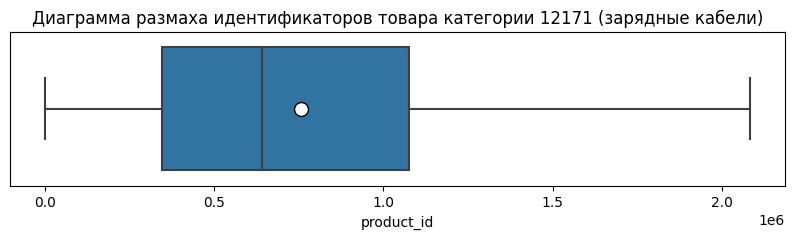

In [16]:
cables_id = train.loc[train['category_id'] == 12171, 'product_id']

# out
table_print(['Статистики product_id\nв категории 12171']
            + [(i, v) for i, v in cables_id.describe().astype(int).items()], 21)

# viz
# отметим также белым кружком среднее значение
plt.subplots(figsize=(10, 2))
sns.boxplot(data=cables_id, orient='h', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
plt.title('Диаграмма размаха идентификаторов товара категории 12171 (зарядные кабели)')
plt.xlabel('product_id')
plt.yticks([])
plt.show()

Как и предполагалось, идентификаторы товаров в данной категории распределены почти по всему пространству идентификаторов. Высокое стандартное отклонение говорит о довольно высокой дисперсии, то есть id товара в данной категории могут быть как очень маленькими, так и очень большими. Хотя очевидных выбросов на диаграмме нет, тот факт, что среднее больше чем медиана, говорит о наличии какой-то части id с большими номерами, выбивающихся из общей картины (скошенность вправо)

В принципе, из разумных соображений сложно представить, что можно организовать какую-то чёткую систему распределения номеров id при таком большом количестве товаров, а также при постоянной ротации ассортимента, добавлении новых товаров и магазинов

**Выводы:**

- Таким образом, можно полагать, что идентификаторы товаров вряд ли описывают какие-то их специфические характеристики, или имеют логическое значение, или другие свойства, которые могут повлиять на принятие решения о категории
- С другой стороны, возможно всё-таки есть какая-то незримая взаимосвязь, какие-то скрытые закономерности, пусть даже очень слабо выраженные. Если принять за гипотезу взаимосвязь идентификатора товара с временем добавления в ассортимент, то возможно, для некоторых товаров мы увидим смещение среднего значения идентификатора в одну или другую сторону (т.е. какие-то товары массово добавлялись раньше, какие-то позже). Таким образом, категория товаров также будет связана со временем добавления. Товаров и категорий много, чтобы визуально отследить это на графиках, поэтому доверим это моделям машинного обучения
- Выдвинем предположение, что использование `product_id` как признаков в машинном обучении не приведет к улучшению качества модели, а напротив, добавит шумов в данные и увеличит вычислительную нагрузку. И проверим это предположение на практике

<br><br><br>

### 1.4 Столбцы `category_id` и `category_name`

Данные столбцы присутствует только в датафрейме `train`, т.к. столбец `category_id` (и опосредованно `category_name`) являются таргетом – нашим целевым признаком

Для id категории товара выведем минимальное, максимальное значение и количество уникальных значений. Также выведем количество уникальных названий категорий:

In [17]:
# out
table_print(['category_id:', train['category_id'], MIN, MAX, COUNT, NUNIQUE, GAP, 
             'category_name:', train['category_name'], COUNT, NUNIQUE])

category_id:
————————————————————————————
Минимальное значение    2599
Максимальное значение  15076
Всего значений         91120
Уникальных значений      874

category_name:
————————————————————————————
Всего значений         91120
Уникальных значений      874


Количество уникальных значений совпадает. Однако даже в этом случае возможны варианты "пересорта" например, id_3:(name_3, name_45) и id_45:(name_45, name_3). Исключим такие варианты, убедившись, что в каждой категории не более одного названия:

In [18]:
head_print('Максимальное количество уникальных названий category_name для любого category_id: ' + 
      f"{train.groupby('category_id')['category_name'].nunique().max()}", 0)

Максимальное количество уникальных названий category_name для любого category_id: 1


Аномалий не выявлено, каждой категории соответствует своё уникальное название

Рассмотрим подробнее категории товаров, составим рейтинг по количеству товаров:

In [19]:
# посчитаем количество товаров в каждой категории и отсортируем по убыванию
cat_products_count = train['category_name'].value_counts().rename('products_count')

# посчитаем процент от общего количества товаров
cat_percent = (cat_products_count * 100 / train.shape[0]).rename('percent')

# посчитаем процент с накоплением и определим, в каком 10-процентном диапазоне находится категория
cat_percent_range = ((cat_percent.cumsum() // 10 + 1) * 10).astype(int).shift(fill_value=10).rename('percent_range')

# объединим 3 серии
categories = pd.concat([cat_products_count, cat_percent, cat_percent_range], axis=1)

# out
head_print('Рейтинг категорий по количеству товаров:')
display(categories)

Рейтинг категорий по количеству товаров:
————————————————————————————————————————


,products_count,percent,percent_range
Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Чехлы,6590,7.232221,10
Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Защитные стекла и пленки->Защитные стекла,3709,4.070457,10
Все категории->Хобби и творчество->Рукоделие->Материалы для рукоделия,1463,1.605575,20
"Все категории->Одежда->Женская одежда->Колготки, носки, чулки->Носки и подследники",1460,1.602283,20
Все категории->Электроника->Наушники и аудиотехника->Наушники->Беспроводные наушники,1222,1.341089,20
Все категории->Товары для дома->Товары для праздников->Оформление праздника->Воздушные шары и аксессуары->Воздушные шары,1215,1.333406,20
Все категории->Хобби и творчество->Стикеры,1168,1.281826,20
Все категории->Товары для дома->Товары для праздников->Открытки и конверты->Открытки,1152,1.264267,20
Все категории->Товары для дома->Товары для праздников->Подарочная упаковка->Пакеты подарочные,1100,1.207199,20
Все категории->Одежда->Мужская одежда->Носки->Носки и подследники,1093,1.199517,30


Видим, что категории в каталоге интернет-магазина представлены в иерархической, древовидной структуре – в корневой категории "Все категории" находятся несколько разделов, которые в свою очередь делятся на подразделы и т.д.

Самые объёмные категории с наибольшим количеством товаров – это аксессуары для сотовых телефонов – "Чехлы" и "Защитные стекла". В сумме они содержат более 10 процентов всех товаров. Также отметим, что есть несколько совсем ненаполненных категорий, всего с одним товаром

Выведем количество категорий, покрывающих определённую долю товаров в датафрейме и визуализируем в виде графика:

Количество категорий по количеству товаров (с разбивкой по 10%):
————————————————————————————————————————————————————————————————


,categories_count,percent
10,2,0.23
20,9,1.03
30,20,2.29
40,39,4.46
50,67,7.67
60,107,12.24
70,164,18.76
80,248,28.38
90,389,44.51
100,874,100.00


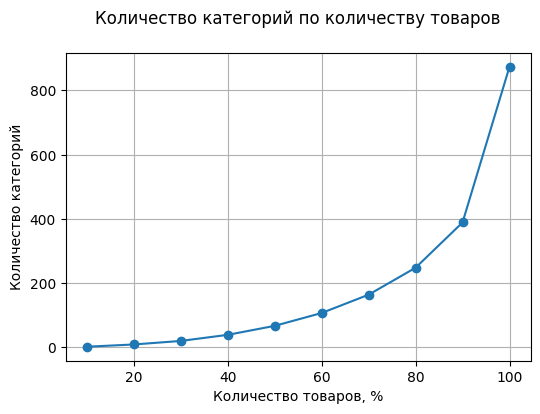

In [20]:
# сгруппируем по процентным диапазонам, просуммируем категории с накоплением и добавим процент от общего числа категорий
n_categories = pd.DataFrame(
    categories['percent_range'].value_counts().sort_index()
    .cumsum().rename('categories_count'))
n_categories['percent'] = round(n_categories['categories_count'] * 100 / len(categories), 2)

# out
head_print('Количество категорий по количеству товаров (с разбивкой по 10%):')
display(n_categories)

# viz
n_categories['categories_count'].plot(marker='o', figsize=(6, 4))
plt.title('Количество категорий по количеству товаров\n')
plt.ylabel('Количество категорий')
plt.xlabel('Количество товаров, %')
plt.grid(axis='both')
plt.show()

Видим, что в общем и целом категории в нашем датафрейме достаточно хорошо наполнены товарами. К примеру, половина всех товаров содержится менее, чем всего в 8% категорий, а 90% всех товаров – менее, чем в 45% категорий

Выведем ТОП-10 самых популярных категорий, с наибольшим количеством товаров (корневую категорию "Все категории" для краткости отображать не будем):

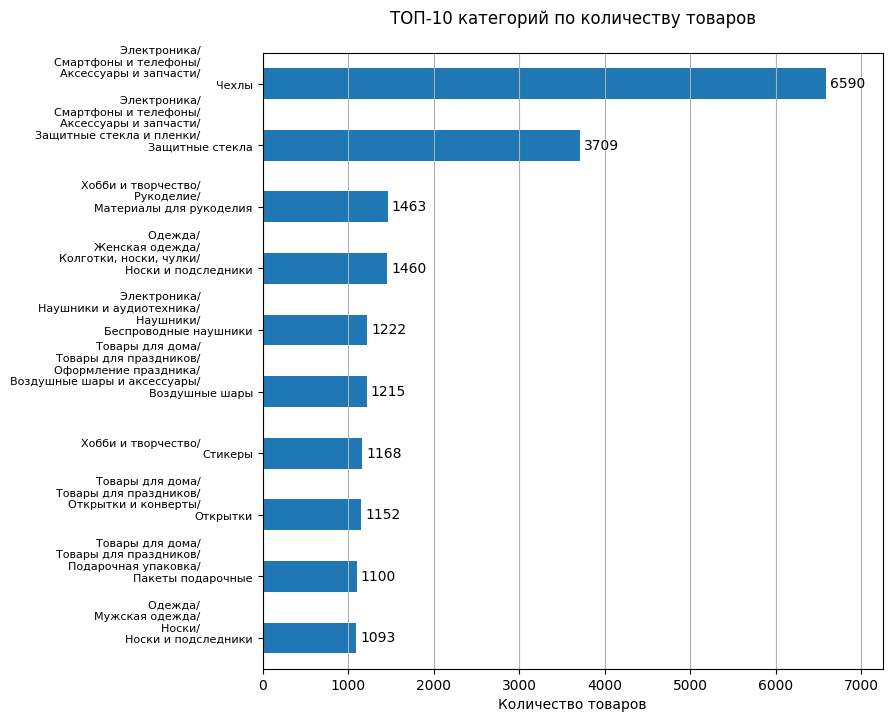

In [21]:
# сформируем ТОП-10 категорий, трансформируем названия категорий для удобства визуализации
cat_top10 = cat_products_count.head(10)
cat_top10.index = [('/' + ' '*15 + '\n').join(i.split('->')[1:]) + '\n'*(len(i.split('->'))-2) for i in cat_top10.index]

# viz
ax = cat_top10.sort_values().plot(kind='barh', tick_label=cat_top10, figsize=(8, 8))
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.margins(x=0.1)
plt.title('ТОП-10 категорий по количеству товаров\n')
plt.xlabel('Количество товаров')
plt.grid(axis='x')
plt.yticks(size=8)
plt.show()

Визуально отрыв первых двух категорий выглядит ещё более убедительно

Интересно заглянуть дальше – какие ещё категории популярны. Выведем ТОП-50:

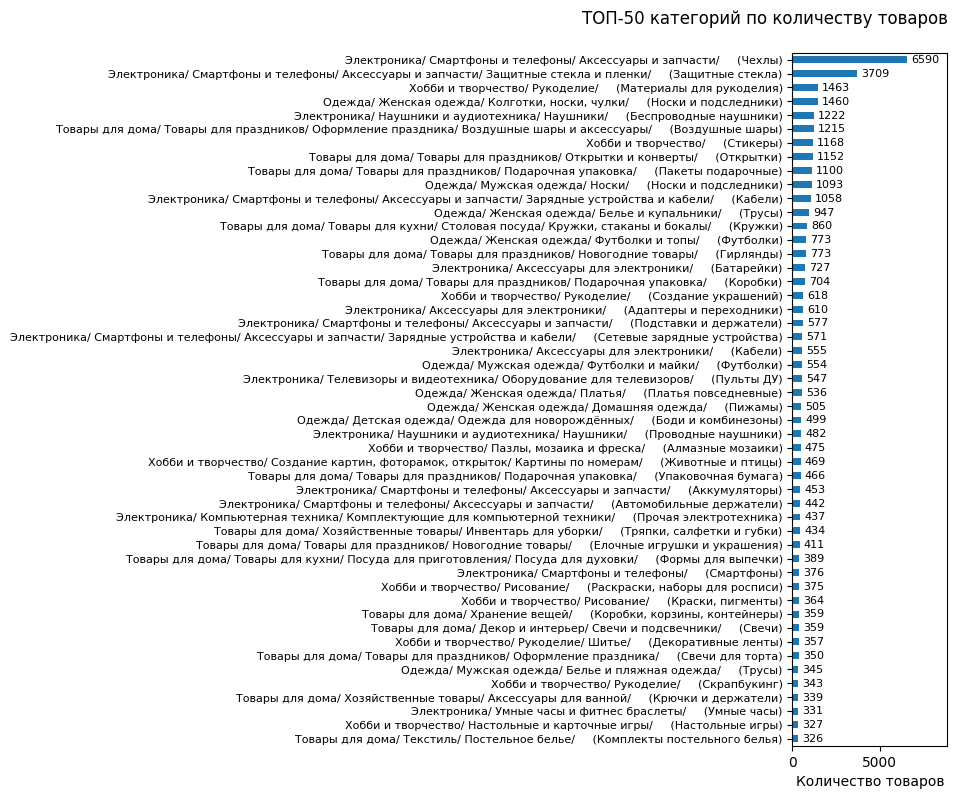

In [22]:
# сформируем ТОП-50 категорий, трансформируем названия категорий для удобства визуализации
cat_top50 = cat_products_count.head(50)
cat_top50.index = [('/ ').join(i.split('->')[1:-1]) + '/     (' + i.split('->')[-1] + ')' for i in cat_top50.index]

# viz
ax = cat_top50.sort_values().plot(kind='barh', tick_label=cat_top50, figsize=(2, 9))
ax.bar_label(ax.containers[0], label_type='edge', padding=3, size=8)
ax.margins(x=0.35)
plt.title('ТОП-50 категорий по количеству товаров\n', loc='right')
plt.xlabel('Количество товаров')
plt.yticks(size=8)
plt.show()

Видим, что основных разделов каталога (т.е. первого уровня иерархии категорий) не так много. В основном встречаются такие разделы, как "Электроника", "Одежда", "Товары для дома", а также "Хобби и творчество"

Выясним, как распределено количество товаров по разделам и сколько всего разделов у нас представлено в датасете:

In [23]:
# добавим в датафрейм столбец с разделом каталога (cat_lev1)
train['cat_lev1'] = train['category_name'].apply(lambda x: x.split('->')[1])

# подсчитаем количество товаров в каждом разделе
cat_lev1 = train['cat_lev1'].value_counts()

# out
table_print(['Список разделов каталога \nс количеством товаров:'] 
            + [(i, v) for i, v in cat_lev1.items()])

Список разделов каталога 
с количеством товаров:
—————————————————————————
Товары для дома     31912
Электроника         26224
Одежда              17010
Хобби и творчество  14346
Обувь                1628


Визуализируем для наглядности:

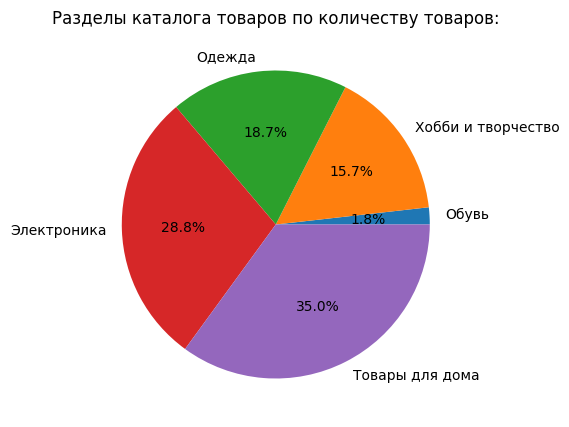

In [24]:
# viz
cat_lev1.sort_values().plot(kind='pie', label='', figsize=(5, 5), autopct='%1.1f%%')
plt.title('Разделы каталога товаров по количеству товаров:')
plt.show()

Видим, что у нас имеются данные только по 5 разделам каталога, хотя на сайте их значительно больше (порядка 20). По количеству товаров сильно выбивается раздел "Обувь" – менее 2%

**Выводы:**

К вопросу более глубокого исследования категорий мы ещё вернёмся в конце раздела, т.к. понимание их структуры и как именно в них располагаются те или иные товары, крайне важно для нашей задачи классификации. А сейчас продолжим исследование остальных столбцов:

<br><br><br>

### 1.5 Столбец `sale`

Выведем для обоих датафреймов количество *True* и *False* значений в столбце:

In [25]:
# out
table_print([
    'Значения train.sale:', 
    ('True', f"{train['sale'].sum():>5}  ({train['sale'].sum() / len(train):>6.2%})"), 
    ('False', f"{len(train) - train['sale'].sum():>5}  ({(len(train) - train['sale'].sum()) / len(train):>6.2%})"), 
    GAP, 'Значения test.sale:', 
    ('True', f"{test['sale'].sum():>5}  ({test['sale'].sum() / len(test):>6.2%})"), 
    ('False', f"{len(test) - test['sale'].sum():>5}  ({(len(test) - test['sale'].sum()) / len(test):>6.2%})")])

Значения train.sale:
——————————————————————
True    1224  ( 1.34%)
False  89896  (98.66%)

Значения test.sale:
——————————————————————
True     205  ( 1.22%)
False  16655  (98.78%)


Наблюдаем большой дисбаланс по данному полю. В обоих датафреймах товары на распродаже составляют менее 1.5% от всего количества

Как правило, распродажи это разовые, непродолжительные, сезонные акции, поэтому опираться на такие данные при разметке категорий будет скорее во вред, чем на пользу. По истечении определенного времени товары, попавшие под распродажу полностью заменятся на другие, из совершенно других категорий, и та часть модели, которая использовала информацию о распродажах и помогала определять категорию более точно, будет давать уже негативный вклад

**Выводы:**

На первый взгляд, этот признак можно считать бесполезным для нашей задачи, а столбец удалить. Проверим это предположение на практике немного позже

<br><br><br>

### 1.6 Столбцы `shop_id` и `shop_title`

Для id магазина выведем минимальное, максимальное значение и количество уникальных значений. Также выведем количество уникальных названий магазинов. Начнём с датафрейма `train`:

In [26]:
# out
table_print(['train.shop_id:', 
             train['shop_id'], MIN, MAX, COUNT, NUNIQUE, GAP, 
             'train.shop_title:', 
             train['shop_title'], COUNT, NUNIQUE])

train.shop_id:
————————————————————————————
Минимальное значение       9
Максимальное значение  62113
Всего значений         91120
Уникальных значений    10549

train.shop_title:
————————————————————————————
Всего значений         91120
Уникальных значений    10549


Теперь всё то же самое для датафрейма `test`:

In [27]:
# out
table_print(['test.shop_id:', 
             test['shop_id'], MIN, MAX, COUNT, NUNIQUE, GAP, 
             'test.shop_title:', 
             test['shop_title'], COUNT, NUNIQUE])

test.shop_id:
————————————————————————————
Минимальное значение       9
Максимальное значение  62109
Всего значений         16860
Уникальных значений     5235

test.shop_title:
————————————————————————————
Всего значений         16860
Уникальных значений     5235


Количество уникальных значений `shop_id` и `shop_title` совпадает и в том, и в другом датафреймах. Исключим варианты "пересорта", убедившись, что каждому id магазина соответствует не более одного названия:

In [28]:
# out
head_print('Максимальное количество уникальных названий shop_title для любого shop_id:')
table_print([('в датафрейме train', train.groupby('shop_id')['shop_title'].nunique().max()), 
             ('в датафрейме test', test.groupby('shop_id')['shop_title'].nunique().max())])

Максимальное количество уникальных названий shop_title для любого shop_id:
——————————————————————————————————————————————————————————————————————————
в датафрейме train  1
в датафрейме test   1


Аномалий не выявлено, у каждого магазина своё уникальное название

Проверим, содержится ли множество магазинов датафрейма `test` полностью в множестве магазинов датафрейма `train` и, если нет, выведем информацию, сколько магазинов `test` отсутствует в `train` и наоборот:

In [29]:
tr, ts = set(train['shop_id']), set(test['shop_id'])

if ts.issubset(tr):
    head_print('Множество магазинов датафрейма test содержится полностью в множестве магазинов датафрейма train', 0)
else:
    trts, tr_ts, ts_tr = len(tr & ts), len(tr - ts), len(ts - tr)
    table_print(['Множество магазинов датафрейма test НЕ содержится полностью в множестве магазинов датафрейма train', 
                 ('Количество магазинов, которые есть и в train, и в test', 
                  f"{trts:>7} {trts / (trts + tr_ts):>9.2%} (train) {trts / (trts + ts_tr):>9.2%} (test)"), 
                 ('Количество магазинов в train, которых нет в test', 
                  f"{tr_ts:>7} {tr_ts / (trts + tr_ts):>9.2%} (train) {tr_ts / (trts + ts_tr):>9.2%} (test)"), 
                 ('Количество магазинов в test, которых нет в train', 
                  f"{ts_tr:>7} {ts_tr / (trts + tr_ts):>9.2%} (train) {ts_tr / (trts + ts_tr):>9.2%} (test)")])

Множество магазинов датафрейма test НЕ содержится полностью в множестве магазинов датафрейма train
——————————————————————————————————————————————————————————————————————————————————————————————————
Количество магазинов, которые есть и в train, и в test     4658    44.16% (train)    88.98% (test)
Количество магазинов в train, которых нет в test           5891    55.84% (train)   112.53% (test)
Количество магазинов в test, которых нет в train            577     5.47% (train)    11.02% (test)


Ввиду того, что почти 90% всех магазинов датафрейма `test` содержится в `train`, рассмотрим данные по магазинам только из датафрейма `train`. На основании этих данных составим рейтинг магазинов по количеству товаров:

In [30]:
# посчитаем количество товаров для каждого магазина и отсортируем по убыванию
shop_products_count = train['shop_title'].value_counts().rename('products_count')

# посчитаем процент от общего количества товаров
shop_percent = (shop_products_count * 100 / train.shape[0]).rename('percent')

# посчитаем процент с накоплением и определим, в каком 10-процентном диапазоне находится магазин
shop_percent_range = ((shop_percent.cumsum() // 10 + 1) * 10).astype(int).shift(fill_value=10).rename('percent_range')

# объединим 3 серии
shops = pd.concat([shop_products_count, shop_percent, shop_percent_range], axis=1)

# out
head_print('Рейтинг магазинов по количеству товаров:')
display(shops)

Рейтинг магазинов по количеству товаров:
————————————————————————————————————————


,products_count,percent,percent_range
Чехлович,1178,1.292801,10
ТВОЕ,895,0.982221,10
ПРОКОНТАКТ,843,0.925154,10
Koton,602,0.660667,10
МИТИНСКИЙ (ОПТОВАЯ БАЗА),559,0.613477,10
...,...,...,...
Топ 100 Опт,1,0.001097,100
Big Bob,1,0.001097,100
InstaSeasons,1,0.001097,100
summertime,1,0.001097,100


Магазины с наибольшим количеством товаров – "Чехлович", "ТВОЕ", "ПРОКОНТАКТ". Судя по названиям ассортимент данных  магазинов составляют, соответственно, аксессуары/чехлы для телефонов, одежда и электроника. В конце списка видны магазины, у которых представлено всего по одному товару

Выведем количество магазинов, представляющих определённую долю товаров в датафрейме и визуализируем в виде графика:

Количество магазинов по количеству товаров (с разбивкой по 10%):
————————————————————————————————————————————————————————————————


,shops_count,percent
10,18,0.17
20,70,0.66
30,168,1.59
40,331,3.14
50,592,5.61
60,1009,9.56
70,1672,15.85
80,2749,26.06
90,4747,45.00
100,10549,100.00


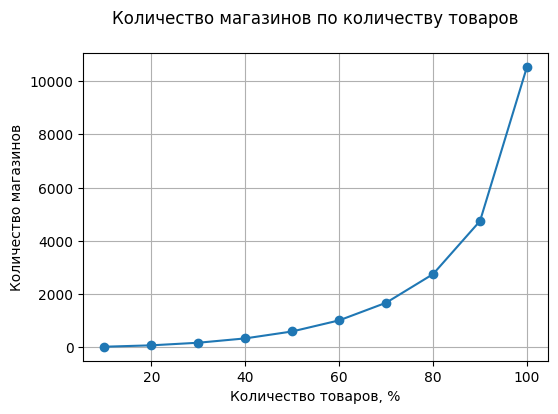

In [31]:
# сгруппируем по процентным диапазонам, просуммируем магазины с накоплением и добавим процент от общего числа магазинов
n_shops = pd.DataFrame(
    shops['percent_range'].value_counts().sort_index()
    .cumsum().rename('shops_count'))
n_shops['percent'] = round(n_shops['shops_count'] * 100 / len(shops), 2)

# out
head_print('Количество магазинов по количеству товаров (с разбивкой по 10%):')
display(n_shops)

# viz
n_shops['shops_count'].plot(marker='o', figsize=(6, 4))
plt.title('Количество магазинов по количеству товаров\n')
plt.ylabel('Количество магазинов')
plt.xlabel('Количество товаров, %')
plt.grid(axis='both')
plt.show()

В целом график похож на аналогичный график количества категорий из пункта 1.2. Половину всех товаров поставляют всего 5.6% магазинов, а 45% магазинов обеспечивают 90% всех товаров

Выведем ТОП-10 магазинов с наибольшим количеством товаров:

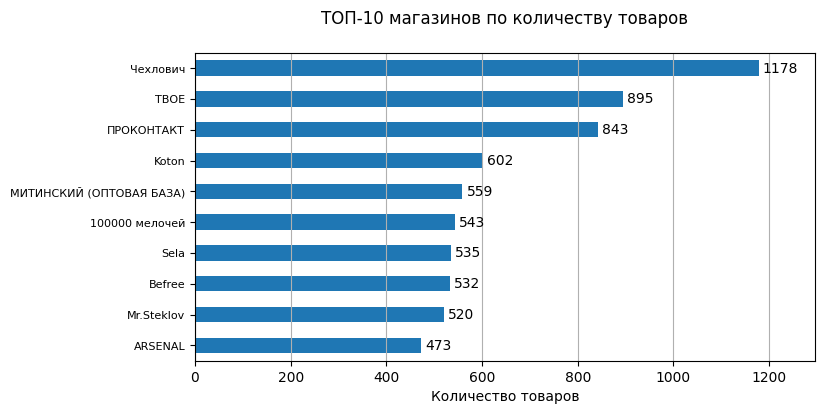

In [32]:
# сформируем ТОП-10 магазинов
shop_top10 = shop_products_count.head(10)

# viz
ax = shop_top10.sort_values().plot(kind='barh', tick_label=shop_top10, figsize=(8, 4))
ax.bar_label(ax.containers[0], label_type='edge', padding=3)
ax.margins(x=0.1)
plt.title('ТОП-10 магазинов по количеству товаров\n')
plt.xlabel('Количество товаров')
plt.grid(axis='x')
plt.yticks(size=8)
plt.show()

Обычно для магазинов выбирают "говорящие" названия и в большинстве случаев по названию можно получить представление, какими именно товарами торгует тот или иной магазин. Кроме того, предположим, что чаще всего магазины специализируются на каком-то конкретном виде товаров. Проверим нашу гипотезу, выведем для каждого магазина из ТОП-10 список разделов каталога, в которых представлены товары:

In [33]:
# для ТОП-10 магазинов сформируем сводную таблицу по магазину и разделу каталога, с количеством записей (товаров)
shop_top10_lev1 = (
    train[train['shop_title'].isin(shop_top10.index)]
    .pivot_table(values='product_id', index=['shop_title', 'cat_lev1'], aggfunc='count')
    .rename(columns={'product_id': 'products_count'}))

# out
head_print('Разделы каталога и количество товаров в них для магазинов из ТОП-10:')
display(shop_top10_lev1)

Разделы каталога и количество товаров в них для магазинов из ТОП-10:
————————————————————————————————————————————————————————————————————


products_count
shop_title               cat_lev1                          
100000 мелочей           Обувь                            7
                         Одежда                           2
                         Товары для дома                278
                         Хобби и творчество             249
                         Электроника                      7
ARSENAL                  Одежда                           1
                         Товары для дома                453
                         Хобби и творчество               8
                         Электроника                     11
Befree                   Обувь                            6
                         Одежда                         526
Koton                    Обувь                            2
                         Одежда                         600
Mr.Steklov               Электроника                    520
Sela                     Одежда                         535
МИТИНСКИЙ (ОПТОВАЯ БАЗА) Электроника                    559
ПРОКОНТАКТ               Товары для дома                  1
                         Хобби и творчество              42
                         Электроника                    800
ТВОЕ                     Обувь                           44
                         Одежда                         851
Чехлович                 Электроника                   1178

На примере ТОП-10 видим, что среди магазинов встречаются т.н. "универсальные", торгующие товарами из нескольких разделов каталога. Однако есть и "специализированные", которые предлагают товары только из какого-то одного конкретного раздела, и таких магазинов, судя по всему, немало

Выведем среднее количество разделов каталога товаров по всем магазинам из нашего датафрейма:

In [34]:
head_print('Среднее количество разделов каталога товаров в магазинах:' + 
           f"{train.groupby('shop_title')['cat_lev1'].nunique().mean():>5.2f}", 0)

Среднее количество разделов каталога товаров в магазинах: 1.31


Видно, что среди всех магазинов преобладают всё-таки специализированные, с товарами из какого-то одного раздела каталога. Выведем количество магазинов по количеству разделов каталога, в которых представлены их товары:

In [35]:
# сгруппируем по названию магазина и посчитаем количество разделов, сгруппируем по разделам, добавим процент
catalog_section_rating = pd.DataFrame(train.groupby('shop_title')['cat_lev1'].nunique().value_counts().rename('shops_count'))
catalog_section_rating['percent'] = round(catalog_section_rating['shops_count'] * 100 / train['shop_id'].nunique(), 2)

# out
head_print('Количество магазинов по количеству разделов каталога:')
display(catalog_section_rating)

Количество магазинов по количеству разделов каталога:
—————————————————————————————————————————————————————


,shops_count,percent
1,8068,76.48
2,1838,17.42
3,506,4.80
4,120,1.14
5,17,0.16


Итак, в нашем датафрейме более 3/4 магазинов, торгующих только в одном разделе каталога, и менее 0.2% (всего 17) магазинов, в которых представлены товары из всех 5 разделов

А что на счёт конечных категорий товаров? Выведем самые узкоспециализированные магазины, которые продают товар только из какой-то одной конечной категории:

In [36]:
# сгруппируем по названию магазина и сопоставим список категорий
shops_1cat_series = train.groupby('shop_title')['category_id'].unique()

# составим список магазинов, представленных только одной категорией товаров
shops_1cat_list = [index for index, value in shops_1cat_series.items() if len(value) == 1]

# посчитаем количество значений в срезе по магазинам/категориям из списка и обернём в датафрейм
shops_1cat_df = pd.DataFrame(train.loc[train['shop_title'].isin(shops_1cat_list), ['shop_title', 'category_name']]
                             .value_counts().rename('products_count'))

# out
head_print('Рейтинг магазинов, торгующих только в какой-то одной категории, по количеству товаров:')
display(shops_1cat_df)

Рейтинг магазинов, торгующих только в какой-то одной категории, по количеству товаров:
——————————————————————————————————————————————————————————————————————————————————————


,,products_count
shop_title,category_name,
ФАБРИКА АККУМУЛЯТОРОВ И БАТАРЕЕК,Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Аккумуляторы,90
Case Discount,Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Чехлы,85
KRUZHKIN,"Все категории->Товары для дома->Товары для кухни->Столовая посуда->Кружки, стаканы и бокалы->Кружки",68
Recom mobile,Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Чехлы,67
Бражник,"Все категории->Товары для дома->Товары для кухни->Приготовление алкоголя->Наборы, ингредиенты для приготовления алкоголя",64
...,...,...
MILANA2022,"Все категории->Одежда->Детская одежда->Одежда для новорождённых->Носки, пинетки",1
MIMIMO,Все категории->Одежда->Детская одежда->Одежда для девочек->Носки и колготки->Колготки,1
MINZIK,Все категории->Товары для дома->Декор и интерьер->Свечи и подсвечники->Свечи,1


Мы получили список из 4371 магазинов, в которых товары представлены лишь в одной категории – это более 41% от всех магазинов датафрейма `train`. Ранее мы выяснили, что почти 90% всех магазинов датафрейма `test` содержится в `train`, так что велика вероятность, что большая часть этих "одно-категорийных" магазинов также встретится и в датафрейме `test`

Казалось бы, магазин из нашего списка однозначно определяет категорию товара, т.к. она для этого магазина единственная.. Очень велик соблазн большую часть задания выполнить без применения ML – просто автоматом разметить целевой признак в `test` по совпадающим в датафреймах магазинам, которые торгуют товарами лишь в конкретных определённых категориях..

Такое решение позволит увеличить итоговую метрику в нашей конкретной задаче, т.к. существенная часть данных `train` будет размечена абсолютно верными категориями. Но, конечно, оно будет некорректным. Рассмотрим его слабые места:

1. Не нужно забывать, что в этом исследовании нам предоставлены далеко не полные данные. Даже основных разделов каталога всего 5 из 20. Возможно, отсутствует и часть подразделов и конечных категорий
<div style="padding-left: 30px; padding-top: 4px; padding-bottom: 4px; "><i>
Простой пример – "ФАБРИКА АККУМУЛЯТОРОВ И БАТАРЕЕК" в топе нашего списка, который якобы торгует только аккумуляторами для сотовых телефонов. А что на счёт обычных бытовых батареек и аккумуляторов? Вероятно, таких категорий в наших урезанных данных просто нет, иначе Фабрика точно "засветилась" бы и в них и не попала бы в наш список
</i></div>
Итак, при масштабировании исследования на полных данных количество "одно-категорийных" магазинов может сильно измениться как в большую, так и в меньшую сторону. Соответственно, мы не можем полагаться на качество предсказания, полученного в данной локальной задаче, ведь метрика также может значительно измениться при масштабировании

2. Предположим даже, что мы обучили модель на полных данных, и что структура каталога и состав и количество магазинов неизменны в ближайшей перспективе.. Но по условию задачи на маркетплейсе *ежедневно появляются сотни новых товаров* и возможна вполне штатная ситуация, когда магазины, ранее представленные у нас только какой-то одной категорией товаров, вводят в ассортимент новые товары из другой категории (которая также есть в нашем каталоге). В этом случае все новые товары будут размечены неправильно

**Выводы:**
- Да, несомненно, информация о магазинах и о его основных категориях, извлеченная моделью из обучающей выборки, конечно могут помочь нам классифицировать товар, однако в большей степени мы должны опираться на неизменную часть - на характеристики самого товара, а именно на гораздо большее количество признаков товара, извлекаемых из текстового описания, табличных данных или изображений
- Пока что кажется разумным оставить столбец `shop_id` в качестве достаточно важного категориального признака для моделей, а столбец с названиями `shop_title` присоединить к остальной текстовой информации. Ведь, как мы выяснили, само название магазина так же может помочь в определении категории, даже без машинного обучения

<br><br><br>

### 1.7 Столбец `rating`

Выведем для оценок рейтинга товара основные статистики и диаграмму размаха:

Статистики по 
оценке товара
—————————————
count 91120.0
mean      4.6
std     0.821
min       1.0
25%     4.581
50%       5.0
75%       5.0
max       5.0


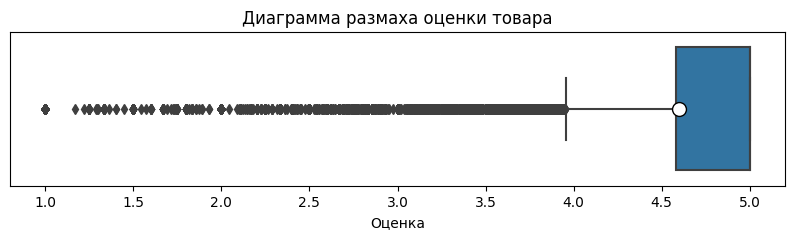

In [37]:
# out
table_print(['Статистики по \nоценке товара']
            + [(i, round(v, 3)) for i, v in train['rating'].describe().items()], 13)

# viz
# отметим также белым кружком среднее значение
plt.subplots(figsize=(10, 2))
sns.boxplot(data=train, x='rating', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
plt.title('Диаграмма размаха оценки товара')
plt.xlabel('Оценка')
plt.yticks([])
plt.show()

- Среднее значение оценок 4.6 указывает на то, что в целом пользователи дали высокие оценки товарам
- Также можно заметить, что 75% всех оценок выше 5, что подтверждает высокую среднюю оценку
- Стандартное отклонение 0.821 говорит о том, что оценки товара имеют довольно высокую дисперсию, то есть пользователи могут давать как достаточно низкие, так и очень высокие оценки
- Медианное значение больше среднего – это говорит об отрицательной асимметрии распределения – длинный хвост и перекос влево, вызванные наличием необычайно малых значений (выбросов) 

Для большей наглядности выведем гистограмму распределения оценок товара:

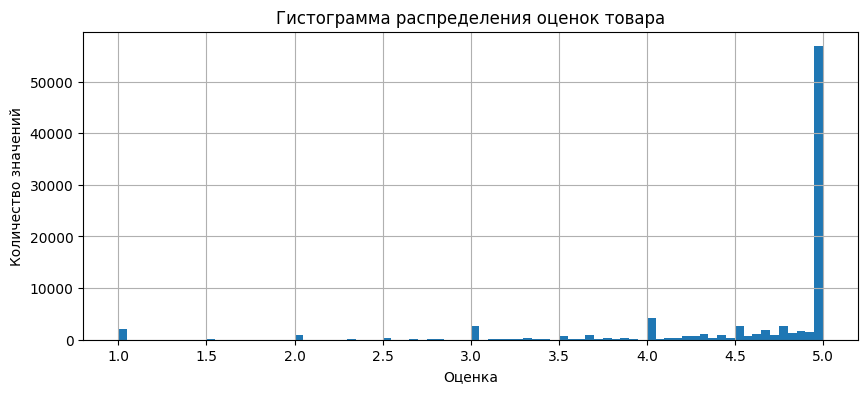

In [38]:
# viz
train['rating'].hist(bins=80, figsize=(10, 4))
plt.title('Гистограмма распределения оценок товара')
plt.xlabel('Оценка')
plt.ylabel('Количество значений')
plt.show()

Как и предполагалось, видим огромный пик на оценке 5 баллов – бесспорный лидер среди всех оценок рейтинга. Кроме того, на графике четко прослеживаются пики на остальных "круглых" значениях оценок: 1, 2, 3, 4, и на их половинках: 1.5, 2.5, 3.5, 4.5 – это проявления свойственной людям тенденции к округлению

Учитывая тот факт, что в столбце нет пропущенных значений, скорее всего при добавлении товара в ассортимент маркетплейса ему автоматически присваиваивается оценка "5". И меняется она, только если пользователь оставит свою оценку товара на сайте

К сожалению, мы не можем разделить количество оценок "5" на те, что проставлялись товарам по умолчанию и те, что на самом деле подвердили пользователи за отличное качество / характеристики / цену товара. Но даже не смотря на это, можно видеть, что в целом хороших оценок (от 4 баллов и выше) гораздо больше остальных, даже вместе взятых

Выведем количество всех оценок по диапазонам через каждые 0.5 баллов:

In [39]:
# out
head_print('Количество оценок в диапазонах по 0.5 балла:')
for a in np.arange(1, 5, .5):
    n_ratings = len(train.query('@a <= rating < @a+0.5'))
    print(f'[{a}, {a+0.5}): {n_ratings:>6} {n_ratings / train.shape[0]:>7.2%}')
n_ratings = len(train.query('rating == 5'))
print(f"Оценок '5': {n_ratings:>6} {n_ratings / train.shape[0]:>7.2%}")

Количество оценок в диапазонах по 0.5 балла:
————————————————————————————————————————————
[1.0, 1.5):   2168   2.38%
[1.5, 2.0):    161   0.18%
[2.0, 2.5):   1133   1.24%
[2.5, 3.0):    597   0.66%
[3.0, 3.5):   3539   3.88%
[3.5, 4.0):   3017   3.31%
[4.0, 4.5):   8879   9.74%
[4.5, 5.0):  15421  16.92%
Оценок '5':  56205  61.68%


Посмотрим теперь, как взаимосвязаны оценки товаров и категории. Выведем рейтинг категорий по средней оценке товаров в них, а также количество товаров:

In [40]:
# группируем по категории, считаем среднее и количество по оценкам, сортируем
cat_rating = train.groupby('category_name')['rating'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

# out
head_print('Рейтинг категорий по средней оценке товаров:')
display(cat_rating)

Рейтинг категорий по средней оценке товаров:
————————————————————————————————————————————


,mean,count
category_name,,
"Все категории->Одежда->Женская одежда->Одежда для беременных->Свитеры, джемперы и кардиганы",5.000000,3
Все категории->Электроника->Умный дом и безопасность->Безопасность дома->Датчики для охранных систем,5.000000,10
Все категории->Одежда->Детская одежда->Одежда для девочек->Футболки и майки->Топы,5.000000,4
Все категории->Одежда->Детская одежда->Одежда для девочек->Толстовки и олимпийки->Олимпийки,5.000000,1
Все категории->Товары для дома->Текстиль->Ковры и ковровые дорожки->Ковры,5.000000,7
Все категории->Одежда->Детская одежда->Одежда для девочек->Платья и сарафаны->Туники,5.000000,5
Все категории->Обувь->Мужская обувь->Ботинки и полуботинки->Полуботинки,5.000000,4
Все категории->Одежда->Детская одежда->Одежда для девочек->Костюмы и пиджаки->Пиджаки и жакеты,5.000000,3
Все категории->Товары для дома->Товары для кухни->Аксессуары для выпечки->Ацетатные пленки,5.000000,5


Выведем основные статистики и диаграмму размаха для средней оценки товара в категориях:

Статистики по 
средней оценке 
в категориях
——————————————
count    874.0
mean     4.619
std      0.313
min      2.548
25%        4.5
50%      4.694
75%      4.825
max        5.0


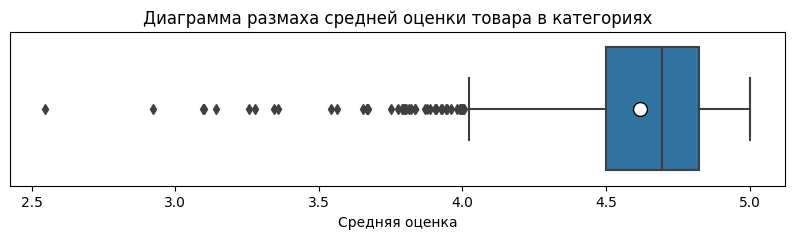

In [41]:
# out
table_print(['Статистики по \nсредней оценке \nв категориях']
            + [(i, round(v, 3)) for i, v in cat_rating['mean'].describe().items()], 14)

# viz
# отметим также белым кружком среднее значение
plt.subplots(figsize=(10, 2))
sns.boxplot(data=cat_rating, x='mean', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
plt.title('Диаграмма размаха средней оценки товара в категориях')
plt.xlabel('Средняя оценка')
plt.yticks([])
plt.show()

Визуализируем распределения категорий по средней оценке товара в виде гистограммы:

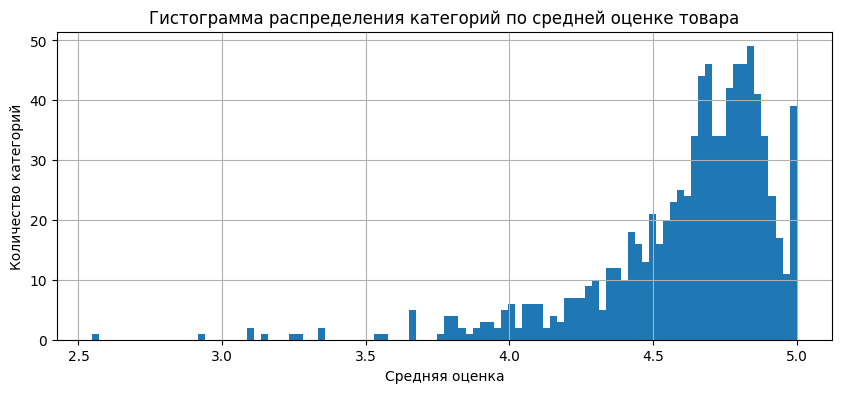

In [42]:
# viz
cat_rating['mean'].hist(bins=100, figsize=(10, 4))
plt.title('Гистограмма распределения категорий по средней оценке товара')
plt.xlabel('Средняя оценка')
plt.ylabel('Количество категорий')
plt.show()

Наблюдаем вполне закономерную картину – усреднение оценки сгладило распределение. Оно по прежнему осталось асимметричным с перекосом влево, однако разрыв между средним значением и медианой существенно сократился. Минимальная оценка уже превышает 2.5 балла, а дисперсия заметно уменьшилась

Посмотрим, как распределены оценки в наших 5 разделах каталога. Выведем среднюю оценку по разделам и диаграммы размаха для каждого раздела:

Рейтинг разделов каталога по средней оценке товаров:
————————————————————————————————————————————————————


,mean,count
cat_lev1,,
Одежда,4.720945,17010
Товары для дома,4.684964,31912
Хобби и творчество,4.677818,14346
Обувь,4.657806,1628
Электроника,4.373251,26224


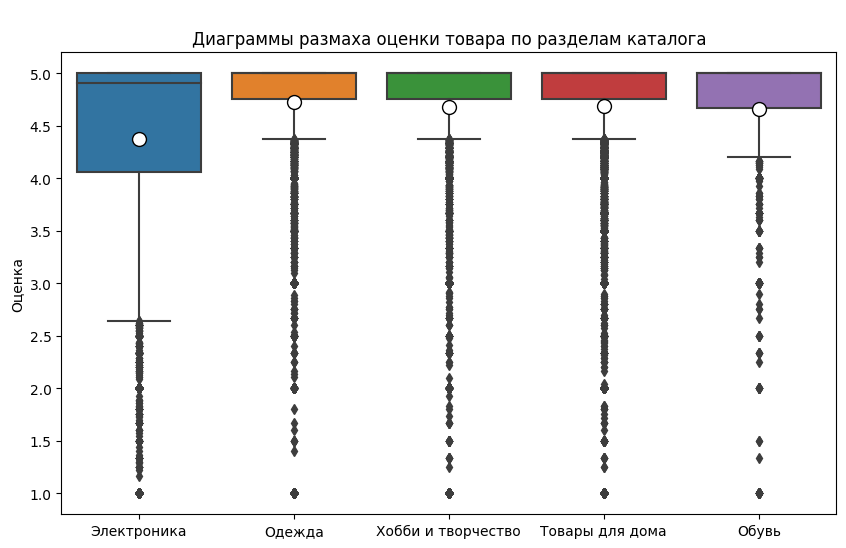

In [43]:
# группируем по разделу, считаем среднее и количество по оценкам, сортируем
cat_lev1_rating = train.groupby('cat_lev1')['rating'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

# out
head_print('Рейтинг разделов каталога по средней оценке товаров:')
display(cat_lev1_rating)

# viz
# отметим также белым кружком среднее значение
plt.subplots(figsize=(10, 6))
sns.boxplot(data=train, x='cat_lev1', y='rating', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})
plt.title('\nДиаграммы размаха оценки товара по разделам каталога')
plt.xlabel(None)
plt.ylabel('Оценка')
plt.show()

Видим, что чаще всего негативные оценки получают товары из раздела "Электроника" – там у них самый низкий средний балл. Возможно товары из данного раздела более подвержены поломкам и производственному браку

**Выводы:**

Пока не совсем ясно, стоит ли включать признаку `rating` в модель обучения для предсказания категории товара. Некоторая зависимость просматривается, нужно экспериментировать и смотреть, даст ли это увеличение качества модели

<br><br><br>

### 1.8 Столбец `text_fields`

Данные в столбце выглядят не очень читаемо для человека – в тексте много лишней информации: служебные названия полей, HTML-теги, дублирование характеристик товара и некоторых символов. Напишем функцию очистки текстовых данных и приведения их в читаемый формат для удобства анализа информации. Задачу упрощает то, что текст записан в JSON-формате и мы легко можем загрузить его сразу в словарь:

In [44]:
# функция-парсер словаря text_fields, возвращает почищенные текстовые данные в виде одной строки
def parse_text_fields(text_fields, showresult=False):
    # удалим html-теги, веб-ссылки, спец-символы html и лишние пробелы
    text = re.sub(r'\</?[^\>]+\>', ' ', text_fields)
    text = re.sub(r'''(?:http[s]?://|www\.)(?:(?!"|'|\s).)+''', ' ', text)
    text = re.sub(r'&[#\w]+;', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()

    # загрузим json-текст в словарь
    tdict = json.loads(text)

    # обработаем строки по ключам title, description и список по ключу attributes
    str1 = tdict['title'].strip(' ')
    str2 = tdict['description'].strip(' ')
    str3 = '. '.join(tdict['attributes'])

    # обработаем вложенные словари по остальным ключам и объединим в единую строку
    dict1 = tdict['custom_characteristics']
    dict2 = tdict['defined_characteristics']
    dict3 = tdict['filters']
    lst = ([key + ': ' + ', '.join(sorted(list(set(value)))) for key, value in dict1.items()] + 
           [key + ': ' + ', '.join(sorted(list(set(value)))) for key, value in dict2.items()] + 
           [key + ': ' + ', '.join(sorted(list(set(value)))) for key, value in dict3.items()])
    str4 = '. '.join(sorted(list(set([value for value in lst if value])))) + '.'

    # oбъединим в одну строку
    result_text = '. '.join([value for value in [str1, str2, str3, str4] if value]).replace('..', '.')

    # если showresult=True, то выведем исходную строку и результат обработки
    if showresult:
        head_print('Исходная строка-словарь:')
        print(text_fields)
        head_print('\nРезультат обработки до объединения строк:')
        print(COLOR + '1: title:           ' + RESET + f'{str1}')
        print(COLOR + '2: description:     ' + RESET + f'{str2}')
        print(COLOR + '3: attributes:      ' + RESET + f'{str3}')
        print(COLOR + '4: characteristics: ' + RESET + f'{str4}')
        head_print('\nИтоговый результат:')
        print(result_text)

    return result_text

Проверим работу нашей функции на примере первой же записи в датафрейме `train`:

In [45]:
# вывод результата обработки текста (задействуем параметр showresult)
parse_text_fields(train.loc[0, 'text_fields'], showresult=True)
pass

Исходная строка-словарь:
————————————————————————
{"title": "Зарядный кабель Borofone BX1 Lightning для айфон, 1м", "description": "<p><span style=\"background-color: transparent; color: rgb(0, 26, 52);\">Зарядный кабель Borofone BX1 подходит для зарядки всех гаджетов и аксессуаров с разъемом </span>Lightning.</p><p><span style=\"color: rgb(0, 26, 52); background-color: transparent;\">Поддерживает быструю зарядку.</span></p><p><span style=\"color: rgb(0, 26, 52); background-color: transparent;\">Подходит для передачи данных.</span></p>", "attributes": ["Длина: 1м", "Разъем: Lightning", "Подерживает быструю зарядку", "Максимальный ток: 2.0А", "Для зарядки и синхронизации данных", "Вес: 22 г."], "custom_characteristics": {}, "defined_characteristics": {"Цвет": ["Черный", "Белый"]}, "filters": {"Цвет": ["Белый", "Черный"]}}

Результат обработки до объединения строк:
——————————————————————————————————————————
1: title:           зарядный кабель borofone bx1 lightning для айфон, 1м
2: descr

Отлично, текст стало намного удобнее читать и анализировать, кроме того, он уменьшился (конкретно в данной ячейке более, чем в 2 раза), при этом мы не потеряли никакой важной информации о товаре. Для машинного обучения этого не достаточно – нужна будет дополнительная чистка и этим мы займемся немного позже

Применим функцию ко всем остальным ячейкам столбца:

In [46]:
%%time
# первичная чистка текста
train['text_fields'] = train['text_fields'].apply(parse_text_fields)
test['text_fields'] = test['text_fields'].apply(parse_text_fields)

CPU times: total: 13.4 s
Wall time: 13.6 s


Выведем для обоих датафреймов количество значений столбца, количество уникальных значений и количество дубликатов:

In [47]:
# out
delta = 'Разница (количество дубликатов)'
table_print(['train.text_fields:', train['text_fields'], COUNT, NUNIQUE, 
             None, (delta, train['text_fields'].count() - train['text_fields'].nunique()), GAP, 
             'test.text_fields:', test['text_fields'], COUNT, NUNIQUE, 
             None, (delta, test['text_fields'].count() - test['text_fields'].nunique())])

train.text_fields:
——————————————————————————————————————
Всего значений                   91120
Уникальных значений              90102
Разница (количество дубликатов)   1018

test.text_fields:
——————————————————————————————————————
Всего значений                   16860
Уникальных значений              16776
Разница (количество дубликатов)     84


Видим, что в столбце есть явные дубликаты – более тысячи повторов значений в датафрейме `train` и почти сотня в датафрейме `test`. Это интересно, ведь, как мы выяснили ранее, идентификаторы товара уникальны

Рассмотрим выборку дубликатов из `train`, выведем первые 20 записей:

Примечание: здесь (и далее в разделе) столбцы `sale` и `rating` пока скроем и в расчёт их не берём

In [48]:
# выведем все дубликаты по text_fields, отсортируем, возьмём первые 20
txt_dup = train[train['text_fields'].duplicated(keep=False)].sort_values(by=['text_fields', 'cat_lev1']).head(20)
head_print('Первые 20 дубликатов датафрейма train по столбцу text_fields:')
display(txt_dup[['product_id', 'category_id', 'shop_id', 'shop_title', 'text_fields', 'category_name', 'cat_lev1']])

Первые 20 дубликатов датафрейма train по столбцу text_fields:
—————————————————————————————————————————————————————————————


,product_id,category_id,shop_id,shop_title,text_fields,category_name,cat_lev1
55989,1487470,13358,41577,Nika-textille,"1,5 сп : пододеяльник 145*210 - 1 шт., простыня 150*210 - 1 шт., наволочки 70*70 см - 2 шт. бязь , плотность 120 гр / кв.м. это отличный материал: хорошо стирается, выдерживает несколько сотен сти...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
89849,1487424,13358,41577,Nika-textille,"1,5 сп : пододеяльник 145*210 - 1 шт., простыня 150*210 - 1 шт., наволочки 70*70 см - 2 шт. бязь , плотность 120 гр / кв.м. это отличный материал: хорошо стирается, выдерживает несколько сотен сти...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
28285,834734,13358,15289,BOTANY,"1,5 спальный 100% хлопок комплект постельного белья бязь. состав материала 100% хлопок 1,5 спальный комплект постельного белья из бязи бязь – это хлопчатобумажная ткань, отличающаяся высокой эколо...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
32997,860644,13358,15289,BOTANY,"1,5 спальный 100% хлопок комплект постельного белья бязь. состав материала 100% хлопок 1,5 спальный комплект постельного белья из бязи бязь – это хлопчатобумажная ткань, отличающаяся высокой эколо...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
36856,860544,13358,15289,BOTANY,"1,5 спальный 100% хлопок комплект постельного белья бязь. состав материала 100% хлопок 1,5 спальный комплект постельного белья из бязи бязь – это хлопчатобумажная ткань, отличающаяся высокой эколо...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
47349,860674,13358,15289,BOTANY,"1,5 спальный 100% хлопок комплект постельного белья бязь. состав материала 100% хлопок 1,5 спальный комплект постельного белья из бязи бязь – это хлопчатобумажная ткань, отличающаяся высокой эколо...",Все категории->Товары для дома->Текстиль->Постельное белье->Комплекты постельного белья,Товары для дома
75753,509100,13571,16706,Империя 3D Наклеек,"3d наклейка-стикер на телефон. в нашем мaгазине вы найдете себе 3d наклейки , которые подчеркнут вашу индивидуальность, душевное состояние, подберете стикеры вызывающие улыбку на лице, с любимыми ...",Все категории->Хобби и творчество->Стикеры,Хобби и творчество
30887,510729,12328,16706,Империя 3D Наклеек,"3d наклейка-стикер на телефон. в нашем мaгазине вы найдете себе 3d наклейки , которые подчеркнут вашу индивидуальность, душевное состояние, подберете стикеры вызывающие улыбку на лице, с любимыми ...",Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Наклейки для телефонов,Электроника
90344,510832,12328,16706,Империя 3D Наклеек,"3d наклейка-стикер на телефон. в нашем мaгазине вы найдете себе 3d наклейки , которые подчеркнут вашу индивидуальность, душевное состояние, подберете стикеры вызывающие улыбку на лице, с любимыми ...",Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Наклейки для телефонов,Электроника
90369,508330,12328,16706,Империя 3D Наклеек,"3d наклейка-стикер на телефон. в нашем мaгазине вы найдете себе 3d наклейки , которые подчеркнут вашу индивидуальность, душевное состояние, подберете стикеры вызывающие улыбку на лице, с любимыми ...",Все категории->Электроника->Смартфоны и телефоны->Аксессуары и запчасти->Наклейки для телефонов,Электроника


Отметим для себя следующие наблюдения (опишем типы возможных дубликатов):
1. Видим, что в основном дубликаты представляют собой полностью повторяющиеся записи – **все поля совпадают**, за исключением значения в столбце `product_id`. Вероятно, такие товары с разным id, но одинаковым текстовым описанием отличаются какими-то другими характеристиками, не указанными в исходных данных (например, расцветка постельного белья, или размер одежды, и т.п.)
2. Также отметим, что в некоторых дублированных строчках также **отличаются категории** (см., например, 2 последних строки выведенного выше списка). В датафрейме `test` такой тип дубликатов отсутствует по причине отсутствия информации по категории товаров
3. Кроме того, возможно есть товары с одинаковым описанием, но которые продаются в **разных магазинах** на маркетплейсе
4. Ну и, наконец, возможно, что одинаковый товар продается в **разных магазинах** и при этом определён в **разные категории** (такой тип также исключён в `test`)

Для проверки наших предположений выведем на экран изображения вышеперечисленных товаров. Для этого сформируем список с названиями файлов (совпадает с id товара). Для удобства разобьём все изображения на серии – в каждой серии товары с одинаковыми описаниями:


————— Серия дубликатов 1 (2 шт) ————————————————————————————————————————————————————————————————————————————————————————


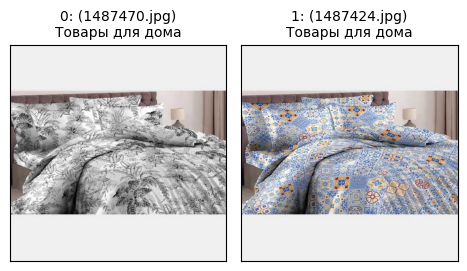


————— Серия дубликатов 2 (4 шт) ————————————————————————————————————————————————————————————————————————————————————————


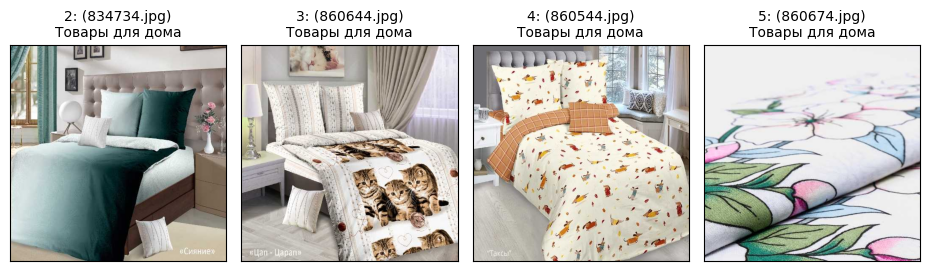


————— Серия дубликатов 3 (4 шт) ————————————————————————————————————————————————————————————————————————————————————————


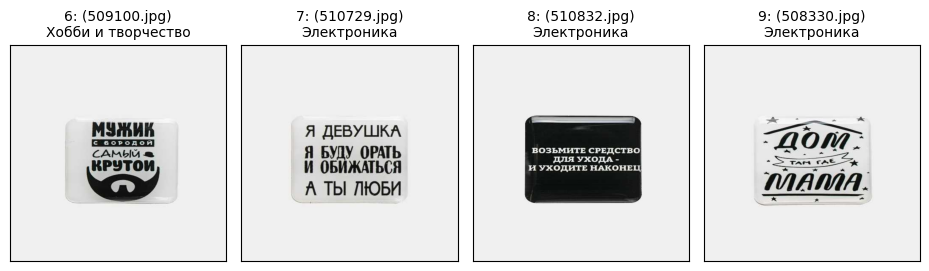


————— Серия дубликатов 4 (4 шт) ————————————————————————————————————————————————————————————————————————————————————————


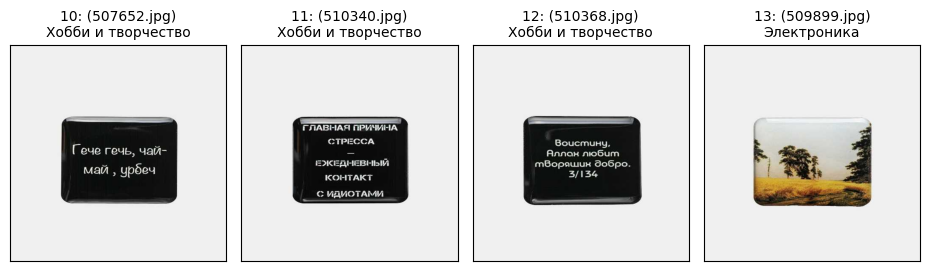


————— Серия дубликатов 5 (4 шт) ————————————————————————————————————————————————————————————————————————————————————————


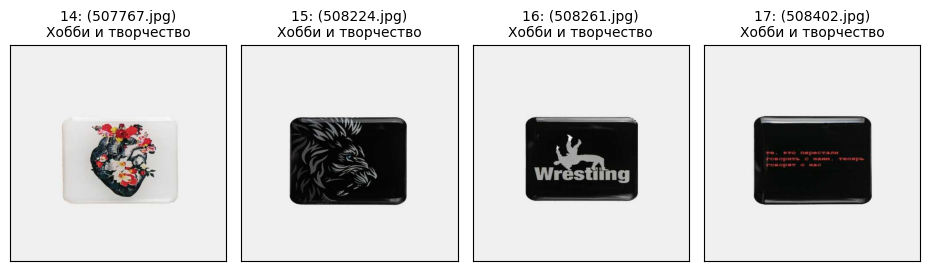


————— Серия дубликатов 6 (2 шт) ————————————————————————————————————————————————————————————————————————————————————————


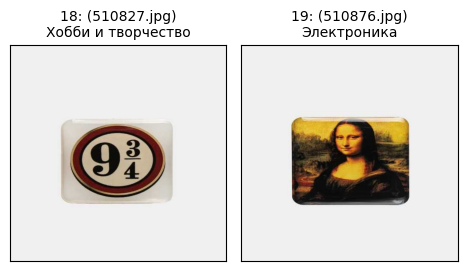

In [49]:
# создадим список с вложенными списками (сериями дубликатов) с названиями файлов изображений
imgs, pack = [], []
for i, index in enumerate(txt_dup.index):
    p = txt_dup.loc[index, 'product_id']
    t = txt_dup.loc[index, 'text_fields']
    pack.append(str(p) + '.jpg')
    if index == txt_dup.index[-1] or (t != txt_dup.loc[txt_dup.index[i+1], 'text_fields']):
        imgs.append(pack)
        pack = []

# viz
path = 'images/train/'
cnt = 0
for j, pack in enumerate(imgs):
    columns = 4
    rows = (len(pack) + (columns - 1)) // columns
    print(COLOR_BOLD + '\n' + '—' * 5 + f' Серия дубликатов {j+1} ({len(pack)} шт) ' + '—' * 88)
    fig = plt.figure(figsize=(9.4, 2.9*rows))
    for i, img in enumerate(pack):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(plt.imread(path + img))
        plt.title(f"{cnt}: ({img})\n{txt_dup.iloc[cnt, -1]}", size=10)
        cnt += 1
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

Одно из наших предположений подтвердилось – действительно, в основном мы наблюдаем одинаковые товары, у которых совпадают все табличные данные, кроме id товара, но которые отличаются прочими характеристиками, не указанными в наших исходных данных (1-й тип дубликатов):
- Первая серия  дубликатов – комплекты постельного белья – отличаются расцветкой
- Вторая и третья серии – аналогично, комплекты белья уже от другого магазина – отличаются также, как минимум, расцветкой
- Серии дубликатов 4, 5, 6 и 7 – стикеры/наклейки – отличаются надписями и картинками

Кроме этого в глаза бросаются стикеры №13 (509899.jpg) в 5-й серии дубликатов и №19 (510876.jpg) в 7-й серии. Помимо того, что на них изображены фрагменты изветных картин ("Рожь" Шишкина и "Мона Лиза" Леонардо да Винчи), что в принципе выбивается из всего шутливого контента остальных наклеек, так они ещё и в другой категории товаров (2-й тип дубликатов, как мы уже заметили ранее по выборке). Вероятно, это ошибка ручной разметки – внесли товар не в тот раздел каталога, но в похожую категорию, либо мы имеем дело с ошибками уже проведенной когда-то ранее автоматической разметки категорий алгоритмами ML

Что на счёт остальных типов дубликатов – есть ли они в наших датафреймах? Посчитаем количество дубликатов каждого типа:

In [50]:
# общее количество дубликатов
train_dup = len(train[train[['text_fields']].duplicated()])
test_dup = len(test[test[['text_fields']].duplicated()])
# type1
train_dup1 = len(train[train[['category_id', 'shop_id', 'text_fields']].duplicated()])
test_dup1 = len(test[test[['shop_id', 'text_fields']].duplicated()])
# type2
train_dup2 = len(train[train[['shop_id', 'text_fields']].duplicated()]) - train_dup1
# type3
train_dup3 = len(train[train[['category_id', 'text_fields']].duplicated()]) - train_dup1
test_dup3 = test_dup - test_dup1
# type4
train_dup4 = train_dup - train_dup1 - train_dup2 - train_dup3
# txt labels
dup = 'Общее (совпадает только описание)'
dup1 = 'Тип 1 (отличий нет, совпадают все поля)'
dup2 = 'Тип 2 (отличается категория)'
dup3 = 'Тип 3 (отличается магазин)'
dup4 = 'Тип 4 (отличаются и категория, и магазин)'

# out
table_print(['Количество дубликатов для датафрейма train:', 
             (dup1, train_dup1), (dup2, train_dup2), (dup3, train_dup3), (dup4, train_dup4), (dup, train_dup), GAP, 
             'Количество дубликатов для датафрейма test:', 
             (dup1, test_dup1), (dup3, test_dup3), (dup, test_dup)])

Количество дубликатов для датафрейма train:
———————————————————————————————————————————————
Тип 1 (отличий нет, совпадают все поля)     954
Тип 2 (отличается категория)                 30
Тип 3 (отличается магазин)                   33
Тип 4 (отличаются и категория, и магазин)     1
Общее (совпадает только описание)          1018

Количество дубликатов для датафрейма test:
———————————————————————————————————————————————
Тип 1 (отличий нет, совпадают все поля)      81
Тип 3 (отличается магазин)                    3
Общее (совпадает только описание)            84


Не будь у нас изображений товаров, мы не задумываясь удалили бы дубликаты 1-го типа из датафрейма `train` – записи, где значения во всех столбцах (кроме `product_id`) совпадают. Ведь такие дубликаты только мешали бы при обучении моделей и отнимали ресурсы. Однако наличие немного отличающихся изображений для одного и того же товара наоборот, как бы обогощает признаки для определения категории. Поэтому удалять такие записи нецелесообразно. Остальных дубликатов (2, 3 и 4 типа) совсем немного, их тоже оставим как есть

Проверим, пересекаются ли множества описаний товаров в `train` и `test` – есть ли описания, присутствующие в обоих датафреймах:

In [51]:
tr, ts = set(train['text_fields']), set(test['text_fields'])
if tr & ts:
    trts, tr_ts, ts_tr = len(tr & ts), len(tr - ts), len(ts - tr)
    title = 'Обнаружены совпадения описаний товаров в датафреймах train и test'
    table_print([title, ('Количество:', f"{trts} = {trts / (trts+tr_ts):.2%}(train) = {trts / (trts+ts_tr):.2%}(test)")], 
                len(title))
else:
    head_print('Совпадений описаний товаров в датафреймах train и test не обнаружено')

Обнаружены совпадения описаний товаров в датафреймах train и test
—————————————————————————————————————————————————————————————————
Количество:                      242 = 0.27%(train) = 1.44%(test)


Выявили 242 совпадающих описания в наших датафреймах. Некоторым описаниям товаров, как мы выяснили раньше, могут соответствовать не одна, а несколько категорий, но таких примеров мало и все они, как правило, связаны с ошибками разметки. И, по идее, сключив такие случаи мы можем смело "предсказать" для остальных описаний товаров (т.е. фактически для самих товаров) 100%-правильную категорию не применяя машинное обучение

Создадим словарь с ключами в виде уникальных описаний товара, которые присутствуют в обоих датафреймах. Значениями по ключам будут идентификаторы категорий, причем в словарь не должны попасть описания, для которых существует более одной категории:

In [52]:
# отфильтруем выборку из датафрейма train только с теми описаниями товаров, которые встречаются в датафрейме test
common_text_df = train.loc[train['text_fields'].isin(ts)]
# print(len(common_text_df))      # == 706: т.к. много дублированных описаний в train

# сгруппируем по описаниям товара и сопоставим каждой группе список категорий, в которых встречается это описание
common_text_series = common_text_df.groupby('text_fields')['category_id'].unique()
# print(len(common_text_series))  # == 242: а тут уже уникальные описания

# создадим словарь с ключами-описаниями и значениями-категориями (только для одиночных категорий)
common_text_dict = {index: value[0] for index, value in common_text_series.items() if len(value) == 1}
# print(len(common_text_dict))    # == 234: нашлось всего 8 описаний, где категорий было более одной

head_print('Количество уникальных описаний товаров в датафрейме test, для которых известно значение таргета:  '
           + f'{len(common_text_dict)}', 0)

Количество уникальных описаний товаров в датафрейме test, для которых известно значение таргета:  234


Итак, словарь создали, его размер 234 текстовых описания. В дальнейшем мы могли бы использовать этот словарь для заполнения части целевых признаков в датафрейме `test` заведомо верными значениями

Проверим, сколько всего значений таргета мы смогли бы автоматом заполнить в датафрейме `test` (возможно, более 234, если для этих описаний в датафрейме `test` найдутся дубликаты):

In [53]:
head_print('Количество всех описаний товаров в датафрейме test, для которых известно значение таргета:  ' 
           + f"{len(test.loc[test['text_fields'].isin(common_text_dict)])}", 0)

Количество всех описаний товаров в датафрейме test, для которых известно значение таргета:  302


Добавилось ещё 68 описаний за счет дубликатов в датафрейме `test`. Итого, в нашей конкретной задаче мы можем заполнить 302 значения целевого признака автоматически, не прибегая к методам ML. Это 1.8% от размера датафрейма `test` – да, не так много, но это гарантированно правильная разметка, которая поможет немного увеличить качество модели. Или нет?

На самом деле, целью предыдущих нескольких ячеек было выяснить, с какими товарами мы имеем дело, лучше разобраться в структуре данных, понять, как они сформированы и чего мы можем от них ожидать в реальной задаче разметки категорий. Определённые полезные выводы мы для себя сделали и на часть вопросов ответили. Что касается "гарантированно правильной" автоматической разметки части данных:

В исходных данных, которые мы получили вместе с заданием, были исключены пересечения товаров в датафреймах `train` и `test` по id товара и это логично и правильно. Однако без внимания остались текстовые описания товаров, по которым мы нашли совпадения. В реальной "боевой" задаче, когда действительно добавляется новый товар, мы не можем знать, будет ли он из тех, что уже есть у нас в ассортименте маркетплейса, (с тем же описанием, но с немного другими характеристиками, например новый стикер), или же это будет абсолютно новый товар с новым описанием. В первом случае мы можем использовать совпадающее текстовое описание, чтобы разметить категорию автоматом. Во втором случае такой возможности не будет

**Выводы:**

- В данной задаче мы не можем использовать совпадающие описания товаров для автоматической разметки части целевого признака, т.к. это ненадёжный и недостоверный способ, который повлечёт за собой искажение итоговой оценки качества модели
- Сам по себе столбец `text_fields` является очень важным источником признаков для обучения моделей классификации товара по категориям

<br><br><br>

### 1.9 Исследование целевого признака

Для выбора наилучшей модели предсказания категории товара нам необходимо более глубоко изучить структуру категорий, понимать каким образом классифицируется товар на нашем маркетплейсе, насколько глубокая и разветвлённая иерархия категорий в каталоге товаров

Часть информации мы можем почерпнуть из столбца `category_name`, однако данные в нем представлены в неудобном формате текстовой строки и требуется предварительная работа, чтобы извлечь из них всю структуру. Кроме того, как мы уже выяснили, у нас в распоряжении только часть всего каталога, а нам хотелось бы видеть всю картину целиком

После непродолжительного исследования сайта нашего маркетплейса был получен файл с полной структурой каталога товаров в формате JSON. Это сильно упрощает задачу. Загрузим его сразу в словарь и исследуем наш целевой признак подробнее:

In [54]:
# загрузим данные из файла в словарь
with open('data_from_site.txt', encoding='utf-8') as json_file:
    cat_json = json.load(json_file)

Во вложенном словаре `makeSearch` корневого словаря `data` среди прочих ключей нас интересует ключ `categoryTree`, по которому находится список всех категорий. Рассмотрим самый первый объект списка:

In [55]:
# выделим список словарей категорий в переменную cat_list
cat_list = cat_json['data']['makeSearch']['categoryTree']

# out
display(cat_list[0])

{'category': {'id': 13915,
  'icon': None,
  'parent': {'id': 10778, '__typename': 'Category'},
  'seo': {'header': 'Учебники для 1 класса',
   'metaTag': 'Учебники для 1 класса',
   '__typename': 'SeoCategoryFields'},
  'title': '1 класс',
  'adult': False,
  '__typename': 'Category'},
 'total': 81,
 '__typename': 'SearchResultCategoryTreeEntry'}

Итак, каждый объект списка соответствует определённой категории. Это словарь, из которого можно извлечь основные интересующие нас данные, а именно: id категории, id родительской категории и название. Мы тут наблюдаем три вида названий: упрощённое название по ключу `title` и более развёрнутые по ключам `header` и `metaTag` вложенного словаря `seo`. После недолгого исследования обнаружили, что в этих двух других названиях есть пропущенные значения и иногда встречаются отличия между собой, а упрощённое название есть в каждой категории, его мы и будем использовать, для наших целей этого вполне достаточно

Было бы интересно ответить на следующие вопросы:
1. Какой минимальный путь от корня дерева до товара?
2. Какой максимальный путь от корня дерева до товара (глубина дерева)?
3. Сколько в среднем ветвлений на каждом уровне дерева?
4. Есть ли товары в промежуточных категориях, или только в конечных?

Для более удобного анализа и более наглядной визуализации переделаем структуру исходного словаря в датафрейм `cats`:

In [56]:
%%time
# создадим датафрейм `cats` и перенесём в него данные из списка словарей
cats = pd.DataFrame(columns=['id', 'name', 'parent'])
for cat in cat_list:
    dct = cat['category']
    cats.loc[len(cats.index)] = [dct['id'], dct['title'], dct['parent']['id'] if dct['parent'] else 0]

CPU times: total: 6.81 s
Wall time: 6.84 s


Заготовка есть. Далее добавим следующие столбцы:
- Со списком id "предков" для каждой категории – путь до корневого раздела каталога (рекурсия)
- С уровнем категории в общей структуре (т.е. с количеством "предков")
- Со списком id подкатегорий ("детей") для каждой категории
- С количеством подкатегорий для каждой категории

In [57]:
# рекурсивная функция сбора предков до корня, возвращает список id предков
def get_parents(cat_id, lst=list()):
    par_id = cats.loc[cats['id'] == cat_id, 'parent'].values[0]
    if par_id == 0:
        return lst
    lst.append(par_id)
    return get_parents(par_id, lst)

In [58]:
%%time
# добавим столбец `parents` со списком предков (путь до корня)
cats['parents'] = cats['id'].apply(lambda x: get_parents(x, []))

# добавим столбец `level` с уровнем категории в иерархии
cats['level'] = cats['parents'].apply(len)

# добавим столбец `childs` со списком веток
cats['childs'] = cats['id'].apply(lambda x: list(cats.loc[cats['parent'] == x, 'id']))

# добавим столбец `n_childs` с количеством подкатегорий
cats['n_childs'] = cats['childs'].apply(len)

CPU times: total: 6.91 s
Wall time: 6.92 s


Далее неплохо бы добавить ещё информацию о количестве товаров и полные названия категорий из исходных данных. Сформируем выборку `cats_train` с информацией о категориях датафрейма `train` и перед тем, как объединить датафреймы, проверим, что все категории исходных данных полностью содержатся в каталоге с сайта маркетплейса (т.е. все id категорий из `cats_train` есть также и в `cats`):

In [59]:
# сгруппируем по id и названию категории и посчитаем количество товаров, сбросим мультииндекс, переименуем столбцы
cats_train = (train[['category_id', 'category_name']].value_counts().rename('n_products')
              .reset_index().rename(columns={'category_id': 'id', 'category_name': 'full_name'}))

# out
# проверим, содержатся ли индексы категорий `cats_train` в `cats`
if set(cats_train['id']).issubset(set(cats['id'])):
    head_print('Множество id категорий `cats_train` содержится полностью в множестве id категорий `cats`', 0)
else:
    head_print('Внимание! Множество id категорий `cats_train` НЕ содержится полностью в множестве id категорий `cats`!')
    print('Следующие категории из `cats_train`, похоже, отсутствуют на сайте маркетплейса:')
    display(cats_train[cats_train['id'].isin(set(cats_train['id']) - set(cats['id']))])

Внимание! Множество id категорий `cats_train` НЕ содержится полностью в множестве id категорий `cats`!
——————————————————————————————————————————————————————————————————————————————————————————————————————
Следующие категории из `cats_train`, похоже, отсутствуют на сайте маркетплейса:


,id,full_name,n_products
702,13939,Все категории->Электроника->Сетевое оборудование->3G/4G роутеры,11


Действительно, проверка на сайте показала, что такой категории, как "3G/4G роутеры", больше нет в каталоге. Все товары из неё были перенесены в соседнюю категорию "Роутеры". Видимо изменения произошли уже после постановки нашей задачи. Будем ориентироваться на исходные данные от заказчика, поэтому просто добавим данную категорию в датафрейм `cats` – заполним строку по образцу соседней категории "Роутеры" (заменим только поля `id` и `name`):

In [60]:
# добавляем новую строку с категорией '3G/4G роутеры' в `cats`
cats.loc[len(cats.index)] = [13939, '3G/4G роутеры'] + list(cats[cats['name'] == 'Роутеры'].values[0])[2:]

# out
head_print('Выведем все категории с роутерами в датафрейме `cats`:')
display(cats[cats['name'].str.contains('оутер')])

Выведем все категории с роутерами в датафрейме `cats`:
——————————————————————————————————————————————————————


,id,name,parent,parents,level,childs,n_childs
2521,13879,Роутеры,11350,"[11350, 10020, 1]",3,[],0
3675,13939,3G/4G роутеры,11350,"[11350, 10020, 1]",3,[],0


Хорошо, категорию с id 13939 добавили. Теперь можно объединять датафреймы `cats` и `cats_train`:

In [61]:
cats = cats.merge(cats_train, how='left', on='id').fillna({'n_products': 0}).astype({'n_products': 'int64'})

Выведем результат:

In [62]:
# out
head_print(f'Датафрейм `cats` для анализа категорий товаров  (строк: {cats.shape[0]}, столбцов: {cats.shape[1]})')
print('Первые 5 строк:')
display(cats.sort_values(by=['level', 'parent', 'id'], ascending=[1, 1, 1]).head())

Датафрейм `cats` для анализа категорий товаров  (строк: 3676, столбцов: 9)
——————————————————————————————————————————————————————————————————————————
Первые 5 строк:


,id,name,parent,parents,level,childs,n_childs,full_name,n_products
3582,1,Все категории,0,[],0,"[10020, 10004, 10014, 10013, 10003, 10012, 10009, 10018, 10016, 10002, 10007, 10008, 10017, 10015, 1821, 10005, 10010, 10019, 10011, 10006]",20,NaN,0
3666,1821,Продукты питания,1,[1],1,"[14285, 1913, 14723, 2475, 2478, 2480, 2483, 2481, 328, 2476]",10,NaN,0
3632,10002,Автотовары,1,[1],1,"[10085, 10233, 10153, 10132, 10188, 10215, 10196, 10135, 10179, 10230, 10111]",11,NaN,0
3603,10003,Аксессуары,1,[1],1,"[14587, 10023, 10021, 10024, 10026, 10022]",6,NaN,0
3591,10004,Бытовая техника,1,[1],1,"[10029, 10027, 2799, 10025, 14699, 10028]",6,NaN,0


Теперь можно ответить на все интересующие нас вопросы:

Минимальный путь от корня дерева до товара это минимальный уровень иерархии (`level`) среди конечных категорий, которые больше не ветвятся (`n_childs` равно нулю). Максимальный путь – глубина дерева, т.е. максимальный `level`. Среднее количество ветвлений вычисляется группировкой по уровню иерархии, а то, есть ли товары в промежуточных категориях – проверкой, что сумма по всем количествам ветвлений (`n_childs`) равна нулю для записей с ненулевым количеством товаров в категории:

In [63]:
# out
head_print(f"1. Минимальный путь от корня дерева до товара: {cats.loc[cats['n_childs'] == 0, 'level'].min()}", 0)
head_print(f"2. Максимальный путь от корня дерева до товара: {cats['level'].max()}", 0)
mean_split = cats[cats['n_childs'] != 0].groupby('level')['n_childs'].mean()
head_print(f"3. Среднее количество ветвлений на каждом уровне: {mean_split.mean():.1f}", 0) 
table_print([('   Уровень '+str(i), f'{v:>8.3f}') 
             for i, v in mean_split.items()])
head_print("4. Товары встречаются не только в конечных, но и в промежуточных категориях" 
           if cats.loc[cats['n_products'] != 0, 'n_childs'].sum() else 
           "4. В промежуточных категориях товаров нет, только в конечных", 0)

1. Минимальный путь от корня дерева до товара: 2
2. Максимальный путь от корня дерева до товара: 5
3. Среднее количество ветвлений на каждом уровне: 9.3
   Уровень 0    20.000
   Уровень 1     9.100
   Уровень 2     7.754
   Уровень 3     5.397
   Уровень 4     4.214
4. В промежуточных категориях товаров нет, только в конечных


Что касается наших исходных данных, исследования показали, что минимальный и максимальный путь от корневого раздела каталога до товара также составляют 2 и 5 (срез по ненулевому количеству товаров). Среднее количество ветвлений чуть меньше, чем в каталоге на сайте, ведь на первом уровне у нас уже всего 5 категорий, вместо 20. Ну и товары находятся так же, только в конечных категориях

In [64]:
# максимальная глубина дерева каталога
max_level = cats.loc[(cats['n_products'] > 0), 'level'].max()

Почему такое внимание было уделено изучению целевого признака? С самого начала показалось, что при таком большом количестве категорий товаров и наличии иерархической структуры каталога, выглядит разумным **классифицировать товары поэтапно**:
- Сначала для каждого товара предскажем первый уровень категорий, т.е. раздел каталога ("Одежда", "Электроника", "Обувь", и т.д.). После первого этапа данные разделятся на 5 групп – по количеству разделов в наших исходных данных. При обучении на полных данных это будет 20 разделов, но всё равно несравнимо меньше, чем количество конечных категорий
- На втором этапе будем делить товары на подкатегории в каждой из 5 групп – т.е., предсказывать второй уровень категорий
- Далее на каждом следующем этапе будем предсказывать следующий уровень категории, пока для каждого товара не дойдём до конечной категории
- В итоге конечные категории товаров сохраняем как результат работы

Использование такого подхода может значительно снизить сложность задачи машинного обучения и требования к вычислительным ресурсам. Кроме того метод может помочь улучшить точность классификации. К примеру, интуитивно кажется, что при достаточно наполненных признаках товара (описания, фото, другие табличные данные) предсказание основного раздела каталога будет почти стопроцентно верным (ведь сложно, например, флешку определить в раздел одежды). Промежуточные подразделы, составляющие иерархическую структуру каталога, обычно также принципиально чем-то отличаются друг от друга (например, одежда – мужская, или женская, или детская), и чаще всего эти отличия отражены в признаках товара

Однако, при таком подходе нужно учитывать, что ошибки, допущенные на более высоком уровне категорий, могут оказаться значительными для классификации на более низком уровне. Поэтому необходимо тщательно выбирать методы классификации для каждого уровня иерархии и контролировать качество классификации на всех уровнях

UPD: Для меня это абсолютно новый метод и раньше я никогда о нем не слышал. Но, конечно же, оказалось, что я "изобрел велосипед". Такой подход, применяемый для иерархической классификации, давно и успешно используется в машинном обучении, причём, как выяснилось, существует несколько его разновидностей

**Выводы:**

Дополнительное исследование целевого признака дало нам информацию о максимальной глубине иерархической структуры категорий (всего 5 уровней) и количестве ветвлений на каждом уровне (в среднем не более 10 и уменьшается с каждым уровнем). Таким образом, для решения нашей задачи видится разумным и целесообразным применить метод поэтапной классификации

<br><br><br>

### 1.10 Подведение итогов изучения и подготовки данных

В рамках первого раздела нашего исследования:
- Были загружены исходные данные – датафреймы `train` и `test`, размерами (91120 х 8) и (16860 х 6) соответственно. Пропущенных значений нет ни в том, ни в другом. Типы данных соответствуют ожидаемым. Необходимость дополнительной предобработки отсутствует
- Проведён исследовательский анализ данных с подробным изучением каждого столбца на предмет аномальных значений, дубликатов, выбросов, но в большей степени на предмет использования его в качестве признака для моделей ML
- Дополнительно изучен целевой признак для определения стратегии построения моделей

**Выводы:**

1. Столбцы `text_fields`, `shop_title`, `shop_id` и `rating` были выбраны в качестве основных признаков для моделей
2. Влияние остальных признаков – `product_id` и `sale` – решено проверить в ходе экспериментов
3. На основании проведённого исследования, учитывая количество категорий, размеры датасета, иерархическую структуру целевого признака и допустимые параметры ветвления, было принято решение использовать в нашей работе метод поэтапной классификации, что позволит разработать максимально лёгкое и нетребовательное к вычислительным ресурсам решение

<br><br><br>

<br><br><br>

# 2. Построение модели обучения

### 2.1 Подготовка к работе, бэкап и восстановление данных

В работе с большими объемами информации и моделями ML, требующими значительных временны́х затрат на обучение, будем придерживаться принципа обкатки решения на урезанных данных. Это, конечно, не даст нам желаемого качества результата, но позволит своевременно заметить слабые места, или ошибки в нашей модели, оперативно всё исправить и отладить. Кроме того, такой подход позволяет приблизительно спрогнозировать итоговое время, необходимое для выполнения кода на полных данных

С этой целью создадим бэкапы наших датафреймов (назовём их `train0` и `test0`), из которых мы можем в любой момент восстановить рабочие датафреймы без загрузки данных и всех предварительных этапов и с возможностью изменить размер выборок. Напишем соответствующую функцию восстановления данных из бэкапа:

In [65]:
# бэкап датафреймов
train0 = train.copy()
test0 = test.copy()

In [66]:
# функция восстановления из бэкапа полных данных (по умолчанию), или урезанных (в размере доли `frac` от исходных)
def restore_samples(train0, test0, frac=1):
    if frac == 1:
        train = train0.copy()
        test = test0.copy()
    else:
        train = train0.sample(frac=frac, random_state=RND)
        test = test0.sample(frac=frac, random_state=RND)
    head_print('Используются датафреймы с ' 
               + ('полными' if frac == 1 else f'урезанными') + ' данными' + ('' if frac == 1 else f' ({frac:.0%})'), 0)
    print(f'train: количество строк: {train.shape[0]:>5}')
    print(f'test:  количество строк: {test.shape[0]:>5}')
    print()
    return train, test

Реализуем последующие блоки кода в виде функций, применяемых к рабочим датафреймам:

<br><br><br>

### 2.2 Объединение и финальная очистка текстовых данных

Напишем функцию подсчёта затраченного времени:

In [67]:
# функция возвращает разницу во времени в виде строки '(**m **s)' или пустую строку, если округленное время меньше секунды
def get_time(t1, t2):
    dt = t2 - t1
    #if int(dt):
    return '(' + (f'{dt//60:.0f}m ' if dt//60 else '') + f'{dt%60:.0f}s)'
    #return ''

Объединим всю текстовую информацию в одном столбце – добавим название магазина в столбец с описанием товара. Ранее мы уже провели предварительную очистку текста в рамках исследовательского анализа данных. Теперь можем провести финальную очистку текста – удалить все символы, кроме русских и английских букв, также удалить одно- и двухбуквенные слова:

In [68]:
# функция возвращает очищенный текст (только русские, англ. буквы и одиночные пробелы)
def clean(text):
    text = text.lower()
    text = text.replace('ё', 'е')
    text = re.sub(r'[^a-zа-я]', ' ', text)    # все символы, кроме русских и англ. букв
    text = re.sub(r'\b\w{1,2}\b', ' ', text)  # слова в 1-2 символа
    text = re.sub(r'\s{2,}', ' ', text)       # более одного пробела
    text = text.strip(' ')
    return text    

In [69]:
# функция объединения и финальной очистки текстовых данных в датафреймах
def cleaning(train, test):
    # объединение текстовых данных (названия магазина и описания товара)
    head_print('Объединение текстовых данных (названия магазина и описания товара)', 0)
    start = time.time()
    train['text'] = train['shop_title'] + ' ' + train['text_fields']
    test['text'] = test['shop_title'] + ' ' + test['text_fields']
    print(f'Готово! {get_time(start, time.time())}')
    print()

    # окончательная чистка текстовых данных
    head_print('Окончательная чистка и подготовка текстовых данных', 0)
    start = time.time()
    print('train: ', end='')
    train['text'] = train['text'].apply(clean)
    print(f'Готово! {get_time(start, time.time())}')

    start = time.time()
    print('test:  ', end='')
    test['text'] = test['text'].apply(clean)
    print(f'Готово! {get_time(start, time.time())}')
    print()

<br><br><br>

### 2.3 Лемматизация текстовых данных

Напишем функцию приведения текстовых данных к нормальным формам слов (лемматизации). Будем использовать подход с созданием словаря лемм для каждого уникального слова в датфреймах. Такой подход по результатам экспериментов увеличил скорость лемматизации в нашем случае в 10 раз:

In [70]:
# функция лемматизации фразы
def lemmatize(text, lemms, stopwords):
    text = [lemms[word] for word in text.split() if word not in stopwords]
    return ' '.join(text)

In [71]:
# функция лемматизации текстовых данных в датафреймах
def lemmatization(train, test):
    # подготовка к лемматизации
    head_print('Формирование множества слов и создание словаря лемм', 0)
    start = time.time()
    morph = pymorphy2.MorphAnalyzer()
    stopwords = nltk_stopwords.words('russian') + nltk_stopwords.words('english')
    # множество всех слов в обоих датафреймах
    words = set(' '.join(set(train['text']).union(set(test['text']))).split())
    # словарь лемм для каждого слова
    lemms = {word: morph.normal_forms(word)[0] for word in words}
    print(f'Готово! {get_time(start, time.time())}')
    print()

    # лемматизация
    head_print('Лемматизация текстовых данных в датафреймах', 0)
    start = time.time()
    print('train: ', end='')
    train['text'] = train['text'].apply(lambda x: lemmatize(x, lemms, stopwords))
    print(f'Готово! {get_time(start, time.time())}')
    
    start = time.time()
    print('train: ', end='')
    test['text'] = test['text'].apply(lambda x: lemmatize(x, lemms, stopwords))
    print(f'Готово! {get_time(start, time.time())}')
    print()

<br><br><br>

### 2.4 Подготовка целевых признаков для каждого этапа классификации

Для реализации метода поэтапной классификации нужна дополнительная подготовка, а именно добавление столбцов с целевым признаком на каждом уровне иерархической структуры категории. Напишем соответствующую функцию:

In [72]:
def adding_class_levels(train, test):
    head_print('Добавление столбцов с категориями на каждом уровне', 0)
    start = time.time()
    # добавим в train столбец со списком предков категории товара
    df = train.merge(cats[['id', 'parents']], how='left', left_on='category_id', right_on='id').set_index(train.index)
    # добавим столбцы вида 'lev*' по количеству уровней иерархической структуры категорий
    for lev in range(1, max_level+1):
        train['lev'+str(lev)] = df.apply(
            lambda row: (row['parents'][::-1] + [row['category_id']])[lev] if len(row['parents']) >= lev else 0, axis=1)
        test['lev'+str(lev)] = 0
    print(f'Готово! {get_time(start, time.time())}')
    print()

После обкатки на урезанных датасетах выведем полученный результат на полных данных:

In [73]:
start = time.time()
train, test = restore_samples(train0, test0)
cleaning(train, test)
lemmatization(train, test)
adding_class_levels(train, test)
head_print(f'Итоговое время: {get_time(start, time.time())[1:-1]}', 0)

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Объединение текстовых данных (названия магазина и описания товара)
Готово! (0s)

Окончательная чистка и подготовка текстовых данных
train: Готово! (18s)
test:  Готово! (3s)

Формирование множества слов и создание словаря лемм
Готово! (39s)

Лемматизация текстовых данных в датафреймах
train: Готово! (54s)
train: Готово! (12s)

Добавление столбцов с категориями на каждом уровне
Готово! (14s)

Итоговое время: 2m 20s


Проверим результат, выведем по 5 первых строк из наших датафреймов:

In [74]:
# out
for df, label in zip([train, test], ['train', 'test']):
    head_print(f'\nДатафрейм `{label}`, количество строк: {df.shape[0]}  Первые 5:')
    display(df[['shop_id', 'rating', 'text'] + ['lev'+str(lev) for lev in range(1, max_level + 1)]].head())


Датафрейм `train`, количество строк: 91120  Первые 5:
——————————————————————————————————————————————————————


,shop_id,rating,text,lev1,lev2,lev3,lev4,lev5
0,9031,5.0,aksik зарядный кабель borofone lightning айфон зарядный кабель borofone подходить зарядка гаджет аксессуар разъём lightning поддерживать быстрый зарядка подходить передача данные длина разъём ligh...,10020,10044,10398,11281,12171
1,18305,5.0,sela трус sela трус слип эластичный бесшовный трикотаж однотонный дизайн средний посадка эластичный пояс ластовица выполнить хлопок модель представить размер цвет чёрный бренд sela размер одежда,10014,10116,11351,14233,0
2,16357,5.0,юнландий канцтовары гуашь юный волшебник цвет больший баночка высокий качество гуашь высокий качество юнландий помочь создать юный художник первый шедевр идеальный нанесение бумага картон дерево с...,10008,10114,13429,0,0
3,34666,4.0,вася nicotine колба кальян крафт разный цвет универсальный колба кальян craft подходить современный кальян уровень вода просматриваться тип соединение уплотнитель материал стекло внутренний диамет...,10008,2779,2780,2789,0
4,26389,4.6,lim market пижама женский однотонный шорты лёгкий ткань комфортный посадка идеальный длина пижама женский шорты выполнить однотонный полиамид стать сам любимый пижама ваш коллекция бельё домашний ...,10014,10116,11116,12834,0



Датафрейм `test`, количество строк: 16860  Первые 5:
—————————————————————————————————————————————————————


,shop_id,rating,text,lev1,lev2,lev3,lev4,lev5
0,22758,5.000000,sky electronics светодиодный лента smart led strip light пульт метр usb bluetooth светодиодный лента led rgb цветной влагостойкий лента пульт usb адаптер возможность управление телефон скачать при...,0,0,0,0,0
1,17729,4.405941,market стекло плёнка керамик матовый honor lite pro psmart lite защитный матовый керамический стекло эффективно защитить экран ваш телефон повреждение благодаря эластичный материал стекло легко гн...,0,0,0,0,0
2,54327,4.000000,visionstore проводной наушник микрофон jack ios android наушник проводной микрофон отличный качество звучание проводной наушник удобный использование мочь выступать гарнитур микрофон компьютер гар...,0,0,0,0,0
3,15000,5.000000,fornails декоративный табличка правило кухня подставка горячий разделочный доска декоративный табличка правило кухня создать неповторимый атмосфера хороший настроение любой кухня комплект иметься ...,0,0,0,0,0
4,39600,5.000000,кухня подставка ложка керамический подложка клубника лаванда лимон подложка керамический рисунок подарочный упаковка сочный яркий рисунок оставить равнодушный подложка стать идеальный подарок пора...,0,0,0,0,0


Итак, всё готово для обучения моделей

"Сохранимся" на этом этапе – обновим наш бэкап, чтобы не пересчитывать  кажый раз всё заново:

In [75]:
# бэкап датафреймов
train0 = train.copy()
test0 = test.copy()

<br><br><br>

### 2.5 Построение модели

Напишем функцию, реализующую алгоритм поэтапной классификации. Вкратце он звучит так: На кажом этапе, для каждой из определённых на предыдущем уровне категорий (делаем срезы по ним, выделяя только нужные данные) мы запускаем отдельную модель, предсказывающую категории текущего уровня и заполняем соответствующий столбец предсказаниями:

In [76]:
# функция поэтапной мультиклассовой классификации
def classification(train, test, model):
    head_print('Выполняется поэтапная классификация категорий товара..', 0)

    # первый уровень иерархии (разделы каталога)
    start0 = start = time.time()
    print(COLOR_BOLD + 'lev1:' + RESET)
    y_train = train['lev1']
    X_train = train.copy()
    X_test = test.copy()
    y_test = model.fit(X_train, y_train).predict(X_test)
    test['lev1'] = y_test
    print(f'Готово! {get_time(start, time.time())}')

    # остальные уровни иерархии
    for lev in range(2, max_level+1):
        start = time.time()
        prev_lev = 'lev' + str(lev-1)
        cur_lev = 'lev' + str(lev)
        prev_cats = list(test[prev_lev].unique())
        print(COLOR_BOLD + cur_lev + f': (для {len(prev_cats)} кат):   ' + RESET)
        # цикл по всем категориям, предсказанным на предыдущем этапе. по ним для фичей будем брать срезы в датафреймах
        for i, cat in enumerate(prev_cats):
            # проверка таргета текущего уровня (если 0, или 0 на предыдущем уровне, продолжаем цикл)
            y_train = train.loc[train[prev_lev] == cat, cur_lev]
            if cat == 0 or y_train.sum() == 0:
                continue
            print(f'{i+1}({cat}) ', end='')
            X_train = train.loc[train[prev_lev] == cat]
            X_test = test.loc[test[prev_lev] == cat]
            # если всего одна подкатегория - модель не используем
            y_test = list(y_train)[0] if y_train.nunique() == 1 else model.fit(X_train, y_train).predict(X_test)
            test.loc[test[prev_lev] == cat, cur_lev] = y_test
        print(f'Готово! {get_time(start, time.time())}')
    print(COLOR_BOLD + f'\nИтоговое время: {get_time(start0, time.time())[1:-1]}' + RESET)

Для того, чтобы передавать в нашу функцию не только модели, но и ансамбли моделей, нужно подавать их в виде пайплайнов. Для этого напишем несколько функций, облегчающих сборку пайплайнов моделей:

In [77]:
# функция, выбирающая текстовый признак в столбце key датасета
class TxtSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X[self.key]

In [78]:
# функция, выбирающая численный признак в столбце key датасета
class NumSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [79]:
# функция сборки пайплайна текстовой модели
def get_txt_model(estimator, column, transformer=None):
    if type(column) == str:
        features = FeatureUnion([(
            column, make_pipeline(TxtSelector(key=column), transformer) if transformer else 
            make_pipeline(TxtSelector(key=column)))])
    else:
        features = FeatureUnion([(
            col, make_pipeline(TxtSelector(key=col), copy.deepcopy(transformer)) if transformer else 
            make_pipeline(TxtSelector(key=col))) for col in column])
    return make_pipeline(features, estimator)

In [80]:
# функция сборки пайплайна численной модели
def get_num_model(estimator, column, transformer=None):
    if type(column) == str:
        features = FeatureUnion([(
            column, make_pipeline(NumSelector(key=column), transformer) if transformer else 
            make_pipeline(NumSelector(key=column)))])
    else:
        features = FeatureUnion([(
            col, make_pipeline(NumSelector(key=col), copy.deepcopy(transformer)) if transformer else 
            make_pipeline(NumSelector(key=col))) for col in column])
    return make_pipeline(features, estimator)

In [81]:
# функция сборки стекинг-модели
def get_stacking_model(estimator, estimators, cv=2):
    return StackingClassifier(estimators=[(str(i+1), estim) for i, estim in enumerate(estimators)],
                              final_estimator=estimator, cv=cv)

Далее встаёт вопрос оценки качества работы нашего алгоритма

Используя метод кросс-валидации, мы можем на каждом этапе контролировать качество каждой отдельно взятой модели, отвечающей за классификацию определённых категорий. Однако, пока не очень понятно, каким образом с помощью этого метода контролировать среднее качество предсказаний на каждом уровне иерархии, а также **итоговое** качество модели в такой поэтапной классификации. Именно эти метрики нас будут интересовать больше всего, поэтому используем самый простой и проверенный метод:

Выделим долю данных из датафрейма `train` под валидационную выборку `valid`. Чтобы применить стратификацию – для сохранения баланса классов и во избежание попадания в валидационную выборку категорий, которых не окажется в обучающей – необходимо удалить "неделимые" категории, т.е., содержащие всего один товар. Таких категорий на полных данных всего 4 и на оценку качества модели они не повлияют. Напишем соответствующую функцию:

In [82]:
# функция выделения части данных (v_frac) для валидационной выборки
def train_valid_split(train, v_frac, class_min_quantity=1):
    # удаляем записи с товарами в категориях < 2, чтобы можно было разделить
    cat_products = train['category_id'].value_counts().sort_values()
    train = train[~train['category_id'].isin(cat_products.loc[cat_products < 2].index)]

    # разделяем на тренировочную и валидационную выборки (valid - пока с таргетами)
    train, valid = train_test_split(train, test_size=v_frac, random_state=RND, stratify=train['category_id'])

    # удаляем записи с товарами в категориях < class_min_quantity, чтобы можно было разделить в стекинге
    if class_min_quantity > 1:
        cat_products = train['category_id'].value_counts().sort_values()
        train = train[~train['category_id'].isin(cat_products.loc[cat_products < class_min_quantity].index)]

    return train, valid

Осталось немного. Напишем функцию вывода результата. Будем отображать конечный результат работы модели – взвешенный f1 score, а также контролировать средний скор на каждом этапе работы модели – на каждом уровне иерархии категорий:

In [83]:
# функция вывода результатов работы модели
def show_results(valid_true, valid):
    head_print(f"Взвешенный F1 score: {f1_score(valid_true['category_id'], valid['category_id'], average='weighted'):.4f}")
    head_print('\nF1 score на разных этапах классификации:', 0)
    for lev in range(1, max_level+1):
        v_true = valid_true['lev'+str(lev)].copy()
        v_pred = valid['lev'+str(lev)].copy()
        # исключаем совпадающие нули, чтоб не завышали оценку (ноль означает отсутствие категории на данном уровне)
        v_true[(v_true == 0) & (v_pred == 0)] = None
        v_pred[(v_pred == 0) & v_true.isna()] = None
        v_true = v_true.dropna()
        v_pred = v_pred.dropna()
        print(f"lev{lev}:  {f1_score(v_true, v_pred, average='weighted'):.4f}")

Соберём все функции в одну общую. Именно ей мы будем запускать каждую нашу модель:

In [84]:
def classify(train, test, model, frac=1, v_frac=0.2):
    # минимальное количество классов для разделения (если используется kfold стекинг модели)
    class_min_quantity = 2 if type(model) == StackingClassifier else 1

    # выделяем часть (frac) из исходных данных (уменьшаем время выполнения алгоритма для отладки и обкатки моделей)
    train, test = restore_samples(train0, test0, frac)

    # выделяем валидационную выборку из train (либо используем тестовую, если v_frac == 0)
    if v_frac:
        train, valid_true = train_valid_split(train, v_frac, class_min_quantity=class_min_quantity)
        valid = valid_true.copy()
        # зануляем таргеты в рабочей валидационной выборке
        valid[['category_id'] + ['lev'+str(lev) for lev in range(1, max_level+1)]] = 0
        # out
        head_print(f'Выделена валидационная выборка ({v_frac:.0%})', 0)
        print(f'train: количество строк: {train.shape[0]:>5}')
        print(f'valid: количество строк: {valid.shape[0]:>5}')
        print()
    else:
        valid = test.copy()

    # запускаем алгоритм классификации
    classification(train, valid, model)

    # записываем в колонку `category_id` итоговый результат - ненулевую категорию максимального уровня из lev*
    valid['category_id'] = valid.apply(
        lambda row: [row['lev'+str(lev)] for lev in range(1, max_level+1) if row['lev'+str(lev)]][-1], axis=1)

    if v_frac:
        print()
        show_results(valid_true, valid)

    return train, valid

Подготовим справочник уже собранных в пайплайны функций для удобной автоматизации их запуска:

In [85]:
# наборы признаков
cols0 = ['txt']
cols1 = ['shop_id', 'rating']
cols2 = ['shop_id', 'rating', 'product_id', 'sale']

# собранные пайплайны моделей
model0 = (get_txt_model(LogisticRegression(random_state=RND), 'text', TfidfVectorizer()), 
          'Текстовые данные (tf-idf векторизация)', cols0)
model1 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols1), 
          'Численные данные (без норм. и кодир.)', cols1)
model2 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols2), 
          'Численные данные (без норм. и кодир.)', cols2)
model3 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols1, StandardScaler()), 
          'Численные данные (StandardScaler)', cols1)
model4 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols2, StandardScaler()), 
          'Численные данные (StandardScaler)', cols2)
model5 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols1, 
                        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), 
          'Численные данные (OrdinalEncoder)', cols1)
model6 = (get_num_model(DecisionTreeClassifier(random_state=RND), cols2, 
                        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), 
          'Численные данные (OrdinalEncoder)', cols2)
model11 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model1[0]], cv=2), 
           'Стекинг: txt + num (без норм.)', cols1)
model12 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model2[0]], cv=2), 
           'Стекинг: txt + num (без норм.)', cols2)
model13 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model3[0]], cv=2), 
           'Стекинг: txt + num (StandardScaler)', cols1)
model14 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model4[0]], cv=2), 
           'Стекинг: txt + num (StandardScaler)', cols2)
model15 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model5[0]], cv=2), 
           'Стекинг: txt + num (OrdinalEncoder)', cols1)
model16 = (get_stacking_model(LogisticRegression(random_state=RND), [model0[0], model6[0]], cv=2), 
           'Стекинг: txt + num (OrdinalEncoder)', cols2)

# список собранных моделей
models = [model0, model1, model2, model3, model4, model5, model6, 7, 8, 9, 10, model11, model12, model13, model14, model15, model16]

<br><br><br>

### 2.6 Первая модель (на tf-idf векторизации текстового признака)

Запустим нашу первую модель! Исследуем взаимосвязь текстового описания товара и его категории, как один из самых перспективных признаков. Векторизацию текста будем проводить при помощи *TfidfVectorizer*:

In [86]:
%%time
v_frac = 0.2   # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 0   # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0.2)    модель 0:    Текстовые данные (tf-idf векторизация),  признаки: ['txt']
————————————————————————————————————————————————————————————————————————————————————————————


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('txtselector',
                                                                  TxtSelector(key='text')),
                                                                 ('tfidfvectorizer',
                                                                  TfidfVectorizer())]))])),
                ('logisticregression', LogisticRegression(random_state=42))])

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выделена валидационная выборка (20%)
train: количество строк: 72892
valid: количество строк: 18224

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (36s)
lev2: (для 5 кат):   
1(10014) 2(10020) 3(10008) 4(10018) 5(10013) Готово! (1m 13s)
lev3: (для 43 кат):   
1(14599) 2(10044) 4(10191) 5(10234) 6(10115) 7(10116) 8(10204) 9(10186) 10(10213) 11(10110) 12(10118) 13(10052) 14(10073) 15(10049) 16(10227) 17(10144) 18(10114) 19(10141) 20(10129) 21(10184) 22(2779) 23(10074) 24(10219) 25(11350) 26(14387) 27(10151) 28(2773) 29(10030) 30(10180) 31(10148) 32(2879) 33(10226) 34(10205) 35(10207) 36(2894) 37(10058) 38(10096) 39(10086) 40(2617) 41(10090) 42(10155) 43(10166) Готово! (1m 10s)
lev4: (для 247 кат):   
1(10221) 2(10398) 6(11120) 7(11340) 8(10680) 9(10695) 10(10533) 12(10559) 14(11163) 16(10313) 17(13330) 18(10095) 19(11097) 20(12440) 21(12842) 23(10858) 25(11351) 2

Итак, мы получили итоговую метрику качества нашей модели, она составила чуть более 0.8. Видим, что действительно, как и предполагалось, самая высокая промежуточная метрика получена на первом этапе, при определении разделов каталога

Также очевидно уменьшение метрики с каждым этапом, по мере углубления в структуру категорий. Данный эффект, как видится, связан с двумя основными факторами:
- Во-первых, с каждым этапом становится всё меньше данных для обучения модели, а в этом случае качество всегда заметно ухудшается
- Во-вторых, как уже было отмечено ранее, имеет место накопление ошибок с предыдущих этапов (если для какого-то товара на первом этапе был неправильно определён раздел каталога, то эта ошибка автоматически переносится на все последующие этапы - данный товар уже не будет правильно классифицирован ни на одном уровне иерархии)

Отметим тот факт, что не смотря на то, что на последнем уровне промежуточная метрика качества упала до 0.7, итоговая метрика качества определения конечной категории всё равно выше – 0.8. Это связано с тем, что на последнем уровне иерархии товаров намного меньше, чем на предыдущих, и большая часть товаров уже была классифицирована ранее и с гораздо более хорошим качеством

Также с огромным воодушевлением отметим скорость обучения – менее 4 минут! На старом маломощном компьютере! Это действительно впечатляет. Кроме того, расход памяти также незначителен (менее 3Гб). Несомненно, это результаты поэтапного подхода. Попытка с наскока запустить модель для предсказания сразу всех категорий за один проход роняло ядро из-за нехватки памяти даже на колабе, а домашний компьютер переставал отображать даже перемещения указателя мышки

Отметим также, что подход с временным урезанием датасета для экспериментов позволил в короткие сроки опробовать несколько моделей. В данной модели используется Логистическая регрессия, показавшая из нескольких опробованных моделей наилучшие результаты в работе с текстовыми векторами, как по качеству прогнозов, так и по скорости работы

Рассмотрим другую модель, включающую в себя признаки из табличных данных (`shop_id` и `rating`):

<br><br><br>

### 2.7 Модель на табличных данных – `shop_id` и `rating`

Следующую модель запустим только на табличных данных `shop_id`, `rating`:

In [87]:
%%time
v_frac = 0.2   # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 1   # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0.2)    модель 1:    Численные данные (без норм. и кодир.),  признаки: ['shop_id', 'rating']
—————————————————————————————————————————————————————————————————————————————————————————————————————————


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('shop_id',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='shop_id'))])),
                                                ('rating',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='rating'))]))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выделена валидационная выборка (20%)
train: количество строк: 72892
valid: количество строк: 18224

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (0s)
lev2: (для 5 кат):   
1(10014) 2(10020) 3(10008) 4(10018) 5(10013) Готово! (0s)
lev3: (для 44 кат):   
1(14599) 2(10044) 4(10191) 5(10118) 6(10110) 7(10116) 8(10204) 9(11350) 10(10213) 11(2773) 12(10115) 13(10052) 14(10049) 15(10073) 16(10074) 17(10114) 18(10129) 19(10144) 20(2779) 21(10219) 22(10141) 23(10207) 24(10186) 25(14387) 26(10184) 27(10151) 28(10030) 29(10180) 30(10058) 31(2894) 32(10148) 33(10234) 34(10096) 35(10086) 36(2617) 37(10227) 38(10090) 39(10166) 40(10226) 41(10155) 42(2879) 43(10205) 44(10150) Готово! (1s)
lev4: (для 277 кат):   
1(10221) 2(10398) 5(11163) 6(12842) 7(11166) 8(10680) 10(12823) 12(10559) 14(10289) 16(10313) 17(12440) 19(10508) 20(10770) 22(11351) 23(10526) 25(10890) 26(10095) 

Что ж, результат не такой хороший, как у предыдущей модели, однако скорость работы несравнимо выше. На табличных данных лучше всех себя показало обычное дерево решений

<br><br><br>

### 2.8 Модель на табличных данных – `shop_id`, `rating`, `product_id` и `sale`

Попробуем добавить ещё два признака:

In [88]:
%%time
v_frac = 0.2   # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 2   # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0.2)    модель 2:    Численные данные (без норм. и кодир.),  признаки: ['shop_id', 'rating', 'product_id', 'sale']
———————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('shop_id',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='shop_id'))])),
                                                ('rating',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='rating'))])),
                                                ('product_id',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='product_id'))])),
                                                ('sale',
                                                 Pipeline(steps=[('numselector',
                                                                  NumSelector(key='sale'))]))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выделена валидационная выборка (20%)
train: количество строк: 72892
valid: количество строк: 18224

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (1s)
lev2: (для 5 кат):   
1(10014) 2(10018) 3(10008) 4(10020) 5(10013) Готово! (1s)
lev3: (для 45 кат):   
1(14599) 2(10115) 4(10191) 5(2779) 6(10073) 7(10116) 8(10204) 9(10044) 10(10118) 11(10213) 12(10151) 13(10049) 14(10074) 15(2773) 16(10114) 17(2894) 18(10129) 19(10052) 20(10184) 21(10180) 22(10144) 23(10110) 24(14387) 25(10148) 26(10219) 27(10141) 28(10207) 29(10030) 30(2879) 31(10086) 32(10166) 33(10186) 34(10234) 35(10096) 36(10227) 37(10058) 38(10090) 39(2617) 40(10226) 41(11350) 42(10176) 43(10155) 44(10150) 45(10205) Готово! (1s)
lev4: (для 288 кат):   
1(10222) 2(11120) 5(10197) 7(11340) 8(10680) 9(10398) 10(11116) 11(10934) 14(10282) 15(10095) 16(12440) 17(11163) 19(10992) 20(10508) 23(10858) 24(11351) 

А ведь скор немного вырос. Неужели в этих двух добавленных признаках, казавшихся абсолютно незначимыми, действительно спрятана взаимосвязь с категорией? Будем проверять дальше

Теперь испробуем метод стекинга, когда на результатах работы двух различных моделей обучается третья модель. Такой подход иногда помогает выделить сильные стороны каждой из моделей первого уровня:

<br><br><br>

### 2.9 Стекинг 1

Итак, у нас есть результаты работы "текстовой" модели и двух "табличных". Используем стекинг, чтобы попробовать объединить усилия моделей:

In [89]:
%%time
v_frac = 0.2   # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 11  # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0.2)    модель 11:    Стекинг: txt + num (без норм.),  признаки: ['shop_id', 'rating']
———————————————————————————————————————————————————————————————————————————————————————————————————


StackingClassifier(cv=2,
                   estimators=[('1',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('text',
                                                                                 Pipeline(steps=[('txtselector',
                                                                                                  TxtSelector(key='text')),
                                                                                                 ('tfidfvectorizer',
                                                                                                  TfidfVectorizer())]))])),
                                                ('logisticregression',
                                                 LogisticRegression(random_state=42))])),
                               ('2',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('shop_id',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='shop_id'))])),
                                                                                ('rating',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='rating'))]))])),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(random_state=42))]))],
                   final_estimator=LogisticRegression(random_state=42))

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выделена валидационная выборка (20%)
train: количество строк: 72892
valid: количество строк: 18224

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (1m 26s)
lev2: (для 5 кат):   
1(10014) 2(10020) 3(10008) 4(10018) 5(10013) Готово! (2m 53s)
lev3: (для 42 кат):   
1(14599) 2(10044) 4(10191) 5(10234) 6(10115) 7(10116) 8(10204) 9(10186) 10(10213) 11(10110) 12(10118) 13(10052) 14(10073) 15(10049) 16(10227) 17(10144) 18(10114) 19(10141) 20(10129) 21(2779) 22(10074) 23(10219) 24(11350) 25(14387) 26(10184) 27(10151) 28(2773) 29(10030) 30(10180) 31(10148) 32(2879) 33(10226) 34(10207) 35(2894) 36(10058) 37(10096) 38(10086) 39(2617) 40(10090) 41(10155) 42(10166) Готово! (2m 38s)
lev4: (для 240 кат):   
1(10221) 2(10398) 6(11120) 7(11340) 8(10680) 9(10695) 10(10533) 12(10559) 14(11163) 16(10313) 17(13330) 18(10095) 19(11097) 20(12440) 21(12842) 23(10858) 25(11351) 27(11166

Время работы заметно подросло. Это объясняется тем, что под капотом у стекинга используется метод перекрестного обучения на разделённой K-Fold'ом выборке, как в кросс-валидации. Поэтому время увеличится, как минимум, кратно числу разбиений на фолды. По умолчанию оно равно 5, но мы для наших экспериментов поставили всего 2

Результат практически не поменялся (даже упал на 0.0005)

<br><br><br>

### 2.10 Стекинг 2

Проверим теперь стекинг на текстовой модели и табличной с 4 признаками:

In [90]:
%%time
v_frac = 0.2   # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 12  # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0.2)    модель 12:    Стекинг: txt + num (без норм.),  признаки: ['shop_id', 'rating', 'product_id', 'sale']
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————


StackingClassifier(cv=2,
                   estimators=[('1',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('text',
                                                                                 Pipeline(steps=[('txtselector',
                                                                                                  TxtSelector(key='text')),
                                                                                                 ('tfidfvectorizer',
                                                                                                  TfidfVectorizer())]))])),
                                                ('logisticregression',
                                                 LogisticRegression(random_state=42))])),
                               ('2',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('shop_i...
                                                                                                  NumSelector(key='shop_id'))])),
                                                                                ('rating',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='rating'))])),
                                                                                ('product_id',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='product_id'))])),
                                                                                ('sale',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='sale'))]))])),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(random_state=42))]))],
                   final_estimator=LogisticRegression(random_state=42))

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выделена валидационная выборка (20%)
train: количество строк: 72892
valid: количество строк: 18224

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (1m 32s)
lev2: (для 5 кат):   
1(10014) 2(10020) 3(10008) 4(10018) 5(10013) Готово! (2m 56s)
lev3: (для 42 кат):   
1(14599) 2(10044) 4(10191) 5(10234) 6(10115) 7(10116) 8(10204) 9(10186) 10(10213) 11(10110) 12(10118) 13(10052) 14(10073) 15(10049) 16(10227) 17(10144) 18(10114) 19(10141) 20(10129) 21(10184) 22(2779) 23(10074) 24(10219) 25(11350) 26(14387) 27(10151) 28(2773) 29(10030) 30(10180) 31(10148) 32(2879) 33(10226) 34(10207) 35(2894) 36(10058) 37(10096) 38(10086) 39(2617) 40(10090) 41(10155) 42(10166) Готово! (2m 40s)
lev4: (для 243 кат):   
1(10221) 2(10398) 6(11120) 7(11340) 8(10680) 9(10695) 10(10533) 12(10559) 14(11163) 16(10313) 17(13330) 18(10095) 19(11097) 20(12440) 21(12842) 23(10858) 25(11351) 27(11166

Результат совсем немного подрос, на 2 тысячных. Можно сказать не изменился

Можно попробовать поднять значение метрики, используя масштабирование или кодирование численнх признаков. Кроме того, в ходе обкатки любой модели на урезанных данных её качество всегда заметно снижалось. Можно попробовать уменьшить валидационную выборку, тем самым увеличив обучающую

Реализация алгоритма в виде удобных функций позволяет автоматизировать вычисления. Не будем приводить скрининги всех прогонов моделей, а подготовим сводную таблицу по результатам наших исследований:

<br><br><br>

# 3. Сравнительный анализ моделей

Выведем таблицу сравнения наших моделей:

In [91]:
model_names = [
    "0: Текстовые данные (tf-idf векторизация),  признаки: ['txt']", 
    "1: Численные данные (без нормализации и кодирования),  признаки: ['shop_id', 'rating']",
    "2: Численные данные (без нормализации и кодирования),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
    "3: Численные данные (StandardScaler),  признаки: ['shop_id', 'rating']",
    "4: Численные данные (StandardScaler),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
    "5: Численные данные (OrdinalEncoder),  признаки: ['shop_id', 'rating']",
    "6: Численные данные (OrdinalEncoder),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
    "11: Стекинг: txt + num (без нормализации),  признаки: ['shop_id', 'rating']",
    "12: Стекинг: txt + num (без нормализации),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
    "13: Стекинг: txt + num (StandardScaler),  признаки: ['shop_id', 'rating']",
    "14: Стекинг: txt + num (StandardScaler),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
    "15: Стекинг: txt + num (OrdinalEncoder),  признаки: ['shop_id', 'rating']",
    "16: Стекинг: txt + num (OrdinalEncoder),  признаки: ['shop_id', 'rating', 'product_id', 'sale']",
]
data = {
    'F1 score (val20%)': [
        0.8014, 0.2619, 0.2971, 0.2620, 0.2970, 0.2631, 0.0615, 0.8012, 0.8035, 0.8013, 0.8036, 0.8029, 0.7995
    ], 
    'time (val20%)': [
        '4m 11s', '3s', '5s', '4s', '8s', '3s', '5s', '9m 49s', '9m 50s', '9m 53s', '10m 1s', '9m 47s', '10m 0s'
    ],
    'F1 score (val10%)': [
        0.8122, 0.2681, 0.3105, 0.2679, 0.3107, 0.2695, 0.0656, 0.8181, 0.8181, 0.8184, 0.8181, 0.8205, 0.8150
    ], 
    'time (val10%)': [
        '4m 19s', '3s', '4s', '4s', '8s', '3s', '5s', '10m 18s', '10m 24s', '10m 23s', '10m 12s', '9m 56s', '10m 3s'
    ]
}

pd.DataFrame(data, index=model_names)

,F1 score (val20%),time (val20%),F1 score (val10%),time (val10%)
"0: Текстовые данные (tf-idf векторизация), признаки: ['txt']",0.8014,4m 11s,0.8122,4m 19s
"1: Численные данные (без нормализации и кодирования), признаки: ['shop_id', 'rating']",0.2619,3s,0.2681,3s
"2: Численные данные (без нормализации и кодирования), признаки: ['shop_id', 'rating', 'product_id', 'sale']",0.2971,5s,0.3105,4s
"3: Численные данные (StandardScaler), признаки: ['shop_id', 'rating']",0.2620,4s,0.2679,4s
"4: Численные данные (StandardScaler), признаки: ['shop_id', 'rating', 'product_id', 'sale']",0.2970,8s,0.3107,8s
"5: Численные данные (OrdinalEncoder), признаки: ['shop_id', 'rating']",0.2631,3s,0.2695,3s
"6: Численные данные (OrdinalEncoder), признаки: ['shop_id', 'rating', 'product_id', 'sale']",0.0615,5s,0.0656,5s
"11: Стекинг: txt + num (без нормализации), признаки: ['shop_id', 'rating']",0.8012,9m 49s,0.8181,10m 18s
"12: Стекинг: txt + num (без нормализации), признаки: ['shop_id', 'rating', 'product_id', 'sale']",0.8035,9m 50s,0.8181,10m 24s
"13: Стекинг: txt + num (StandardScaler), признаки: ['shop_id', 'rating']",0.8013,9m 53s,0.8184,10m 23s


Видим, что стекинг в большинстве случаев дает прирост, но он совсем незначительный. Также очевидно, что увеличение данных благоприятно сказывается на все наши модели. Максимального значения метрики на валидационной выборке 0.82 достигает модель стекинга текстовой модели и табличной с двумя признаками: 'shop_id' и 'rating' и порядковым кодированием

Запустим эту модель на тестовой выборке, без выделения валидационной:

In [92]:
%%time
v_frac = 0     # размер валидационной выборки
frac = 1       # доля обучающей выборки от исходных данных
m_number = 15  # номер модели в "справочнике" выше

#out
m_label = models[m_number][1]
head_print(f'\n(fr={frac}  v_fr={v_frac})    модель {m_number}:    {m_label},  признаки: {models[m_number][2]}')
display(models[m_number][0])

# вывод результатов и информации по обучению модели
train, valid = classify(train, test, models[m_number][0], frac, v_frac)


(fr=1  v_fr=0)    модель 15:    Стекинг: txt + num (OrdinalEncoder),  признаки: ['shop_id', 'rating']
——————————————————————————————————————————————————————————————————————————————————————————————————————


StackingClassifier(cv=2,
                   estimators=[('1',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('text',
                                                                                 Pipeline(steps=[('txtselector',
                                                                                                  TxtSelector(key='text')),
                                                                                                 ('tfidfvectorizer',
                                                                                                  TfidfVectorizer())]))])),
                                                ('logisticregression',
                                                 LogisticRegression(random_state=42))])),
                               ('2',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('shop_i...
                                                                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                 unknown_value=-1))])),
                                                                                ('rating',
                                                                                 Pipeline(steps=[('numselector',
                                                                                                  NumSelector(key='rating')),
                                                                                                 ('ordinalencoder',
                                                                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                 unknown_value=-1))]))])),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(random_state=42))]))],
                   final_estimator=LogisticRegression(random_state=42))

Используются датафреймы с полными данными
train: количество строк: 91120
test:  количество строк: 16860

Выполняется поэтапная классификация категорий товара..
lev1:
Готово! (1m 50s)
lev2: (для 5 кат):   
1(10020) 2(10018) 3(10014) 4(10008) 5(10013) Готово! (3m 30s)
lev3: (для 42 кат):   
1(10129) 2(10044) 3(10144) 4(10115) 5(10116) 6(10114) 7(10151) 8(10049) 9(10207) 10(10052) 11(10074) 12(14599) 13(10118) 14(10110) 15(10148) 16(10073) 17(2779) 18(10155) 19(10213) 20(10204) 21(10219) 22(10191) 23(10141) 24(10227) 25(10058) 26(14387) 27(10186) 28(10180) 30(2773) 31(10184) 32(10090) 33(2894) 34(11350) 35(10234) 36(10030) 37(2879) 38(2617) 39(10166) 40(10226) 41(10086) 42(10096) Готово! (3m 19s)
lev4: (для 247 кат):   
1(10908) 2(10398) 3(11157) 4(10890) 5(10289) 6(11166) 7(11351) 11(10858) 13(10937) 14(11379) 15(11087) 16(10222) 17(10313) 18(10934) 19(12823) 20(10533) 21(11390) 22(11009) 23(10586) 24(10390) 26(10221) 27(10095) 29(11088) 30(12440) 31(11376) 32(10680) 33(11163) 35(11120) 

Запишем результат в файл `result.parquet`:

In [93]:
valid[['product_id', 'category_id']].rename(columns={'category_id': 'predicted_category_id'}).to_parquet('result.parquet')

<br><br><br>

# 4. Выводы

Перед нами стояла задача мультиклассовой классификации - необходимо было по исходным данным определить категорию товара интернет магазина KazanExpress

В рамках нашего исследования мы загрузили, изучили и обработали исходные данные. Был проведён глубокий исследовательский анализ с подробным изучением каждого столбца на предмет использования в качестве признака для моделей ML. Дополнительно изучен целевой признак для определения стратегии построения моделей

На основании проведённого исследования, учитывая количество категорий, размеры датасета, иерархическую структуру целевого признака и допустимые параметры ветвления, было принято решение использовать в нашей работе метод поэтапной классификации, что позволит разработать максимально лёгкое и нетребовательное к вычислительным ресурсам решение

В качестве основных признаков для моделей были выбраны столбцы `text_fields`, `shop_title`, `shop_id` и `rating`. Влияние остальных признаков было решено проверить экспериментально

**Выводы:**

1. Выбранный метод поэтапной классификации показал свою эффективность и быстродействие. Все модели в рамках данного исследования обучались не более 10 минут
2. Наибольший вклад в качество модели дают текстовые данные
3. Влияние остальных признаков – `product_id` и `sale` – оказалось абсолютно несущественным
4. метод стекинга в данном конкретном случае не принес значительного улучшения, но, тем не менее, лучшая модель в этом проекте использует именно его

**Результат:**

Лучшей моделью в рамках данного исследования была признана модель стекинга на текстовой и табличной моделях. Оценочная метрика на валидационной выборке – взвешенный f1 score – составил 0.82. Вероятно, итоговый результат, рассчитанный для тестовой выборки на полных данных, будет немного выше за чсет увеличения данных для обучения

**Дальнейшие планы:**

За недостатком вычислительных ресурсов и времени к сожалению не были рассмотрены и опробованы более технологичные, но более ресурсоемкие решения, такие как продвинутые языковые модели типа Bert, нейронные сети, в том числе обработка изображений и использование их в качестве входных данных

In [94]:
head_print(f'Общее время выполнения проекта {get_time(start_prj, time.time())}\n', 0)
head_print('Спасибо за внимание и интерес, проявленный к данной работе!', 0)

Общее время выполнения проекта (36m 49s)

Спасибо за внимание и интерес, проявленный к данной работе!
